# Flight Price Forecast - Kiwi


This notebook presents a full data science pipeline for forecasting flight prices using data from the **Kiwi** platform.  
The process begins with structured data cleaning and preprocessing, including handling missing values, converting date and duration fields, and encoding categorical features (such as number of stops).

Following the preparation phase, we explore the data (EDA) to uncover trends, distributions, and potential outliers.

Then, we evaluate multiple regression models for price prediction, including:

- **Linear Regression**
- **Decision Tree**
- **Gaussian Process**
- **Random Forest**
- **K-Nearest Neighbors**
- **Multi-layer Perceptron**
- **XGBoost**
- **HistGradientBoosting**

Each model is assessed using metrics like: **R², RMSE, MSE**, and **MAE**.  
To enhance interpretation, we include **residual plots**, **feature importance (permutation)**, and **actual vs. predicted** visualizations.

 This analysis is part of a dual-platform comparison (Kiwi & Kayak).  
A separate notebook applies the same methodology to the Kayak dataset.

## Stage No. 1: collecting the data:
- for this stage we will use a web scraper-collector that will collect flights data from two websites: Kiwi and Kayak.
- this collector is built with async-runtime functions, random user-actions generator, session saver, cookies saver, dynamic viewport and even DHCP-ip-refresher function (since were not using proxy), all of these methods are used for collecting without getting cought by these websities bot-identifier machenisms...
- this collector will run every combination of ttt (time to travel) from 1-30, los (lenght of stay) from 1-5 within a 3 different snapshot days for every combination of rome,london and paris routes

In [1]:
%pip install -e scraping
# %playwright install

Obtaining file:///C:/Users/LaurenM/OneDrive/Desktop/flight_price_forecasting_and_clustering/scraping
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for scraping (pyproject.toml): started
  Building editable for scraping (pyproject.toml): finished with status 'done'
  Created wheel for scraping: filename=scraping-0.1-0.editable-py3-none-any.whl size=2637 sha256=036fa0a197d27adfe8896f69d8907b36cba8e06b1bb0d36aeef33e6c4fd8ce85
  Stored in directory: C:\Users\LaurenM\AppData\Local\Temp\pip-ephem-wheel-cache-17jb0hij\wheels\4f\61\


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import re, time, random, datetime, math
from datetime import datetime
from tqdm import tqdm

In [3]:
##################### Preprocessing imports 
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from category_encoders import TargetEncoder, HashingEncoder, CountEncoder
from sklearn.impute import KNNImputer

##################### Metrics
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

##################### Models
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline

##################### Model selection 
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingRegressor
from sklearn.inspection import permutation_importance
from sklearn.base import clone
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import minimize
from IPython.display import clear_output
from concurrent.futures import ThreadPoolExecutor
from scipy.stats import skew, kurtosis

##################### optuna library import
# !pip install shap
import optuna
import shap
import matplotlib.cm as cm
from collections import defaultdict
from currency_converter import CurrencyConverter

##################### Basic settings
random_state = 42
n_splits = 5

 Exploring the data

In [4]:
data1 = pd.read_csv('data_kiwi_balanced.csv')

In [5]:
# Table for first look
def summary(train):
    sum = pd.DataFrame(train.dtypes, columns=['dtypes'])
    sum['missing#'] = train.isna().sum()
    sum['missing%'] = (train.isna().sum())/len(train)
    sum['uniques'] = train.nunique().values
    sum['count'] = train.count().values
    return sum

display(summary(data1).style.background_gradient(cmap='Blues'))
data1.head()

,dtypes,missing#,missing%,uniques,count
departure_hour,object,0,0.000000,195,97092
departure_airport,object,5223,0.053794,11,91869
flight_length,object,0,0.000000,129,97092
landing_hour,object,4235,0.043618,193,92857
landing_airport,object,4502,0.046368,10,92590
to_dest_company,object,8677,0.089369,21,88415
return_departure_hour,object,0,0.000000,199,97092
return_departure_airport,object,5195,0.053506,198,91897
return_flight_length,object,0,0.000000,124,97092
return_landing_hour,object,5195,0.053506,198,91897


,departure_hour,departure_airport,flight_length,landing_hour,landing_airport,to_dest_company,return_departure_hour,return_departure_airport,return_flight_length,return_landing_hour,...,ttt,los,snapshot_date,origin_city,destination_city,departure_date,return_date,website,layover_time,return_layover_time
0,06:35,FCO,2h 45m,08:20,LGW,Wizz Air Malta,09:10,12:40,2h 30m,12:40,...,2,1,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kiwi,0m,0m
1,06:35,FCO,2h 45m,08:20,LGW,Wizz Air Malta,21:00,NaN,2h 30m,NaN,...,2,1,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kiwi,0m,0m
2,06:45,FCO,2h 50m,08:35,LGW,Vueling,09:10,12:40,2h 30m,12:40,...,2,1,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kiwi,0m,0m
3,06:00,CIA,2h 45m,07:45,STN,Ryanair,09:10,12:40,2h 30m,12:40,...,2,1,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kiwi,0m,0m
4,06:35,FCO,2h 45m,08:20,LGW,Wizz Air Malta,18:10,21:35,2h 25m,21:35,...,2,1,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kiwi,0m,0m


##  Preprocessing
<!-- <ul>
    <li>basic_cleanups</li>
    <li></li>
    <li></li>
</ul> -->

the price is still an object! we need to convert it to numerical... (with scraping knowlage we know that kiwi gives the price in nis and kayak in $)

In [6]:
%pip install currencyconverter

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
def basic_cleanups(data):
    data = data.drop_duplicates()
    data = data.dropna()

    c = CurrencyConverter()

    data['price'] = data['price'].apply(
        lambda x: (
            c.convert(float(x.replace('₪ ', '').replace(',', '')), 'ILS', 'USD') if '₪ ' in x
            else float(x.replace('$', '').replace(',', '')) if '$' in x 
            else None 
        )
    )
    return data

we will add a function that will convert the time strings to int (in minutes)

In [18]:
def time_to_minutes(time_str: str)-> int:
    if pd.isna(time_str):
        return 0

    # Extract hours and minutes using regex
    hours = 0
    minutes = 0
    
    h_match = re.search(r'(\d+)h', time_str)
    m_match = re.search(r'(\d+)m', time_str)

    if h_match:
        hours = int(h_match.group(1))
    if m_match:
        minutes = int(m_match.group(1))

    return hours * 60 + minutes

In [19]:
def hour_to_numeric(hour_str):
    '''
    convert the hours to int format
    '''
    hour_str = hour_str.strip()  

    match = re.search(r"\+(\d+)", hour_str)
    extra_days = int(match.group(1)) if match else 0
    hour_str = re.sub(r"\+\d+", "", hour_str)
    
    if 'a' in hour_str or 'p' in hour_str:
        hour_str = hour_str.replace('a', 'AM').replace('p', 'PM')

        time_obj = datetime.strptime(hour_str, "%I:%M%p")
    else:
        time_obj = datetime.strptime(hour_str, "%H:%M")

    hour_float = time_obj.hour + time_obj.minute / 60

    hour_float += extra_days * 24

    return hour_float


In [16]:
def preprocessing(data):
    # perform basic cleanups
    data = basic_cleanups(data)

    # convert time to minutes
    data['flight_length'] = data['flight_length'].apply(time_to_minutes)
    data['return_flight_length'] = data['return_flight_length'].apply(time_to_minutes)
    data['layover_time'] = data['layover_time'].apply(time_to_minutes)
    data['return_layover_time'] = data['return_layover_time'].apply(time_to_minutes)

    # convert hours to numeric
    data['departure_hour'] = data['departure_hour'].apply(hour_to_numeric)
    data['landing_hour'] = data['landing_hour'].apply(hour_to_numeric)
    data['return_departure_hour'] = data['return_departure_hour'].apply(hour_to_numeric)
    data['return_landing_hour'] = data['return_landing_hour'].apply(hour_to_numeric)

    # convert date to datetime
    ## we know that dates are tied to day of week, lets create new feature based on the departure date!
    data['departure_date'] = pd.to_datetime(data['departure_date'])
    data['day_of_week'] = data['departure_date'].dt.day_name()

    # create new feature based on the origin_city and destination_city
    data['route'] = data['origin_city'] + '_' + data['destination_city']

    return data

data1 = preprocessing(data1)
data1.head()

,departure_hour,departure_airport,flight_length,landing_hour,landing_airport,to_dest_company,return_departure_hour,return_departure_airport,return_flight_length,return_landing_hour,...,snapshot_date,origin_city,destination_city,departure_date,return_date,website,layover_time,return_layover_time,day_of_week,route
0,6.583333,FCO,165,8.333333,LGW,Wizz Air Malta,9.166667,12:40,150,12.666667,...,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kiwi,0,0,Sunday,ROME_LONDON
2,6.750000,FCO,170,8.583333,LGW,Vueling,9.166667,12:40,150,12.666667,...,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kiwi,0,0,Sunday,ROME_LONDON
3,6.000000,CIA,165,7.750000,STN,Ryanair,9.166667,12:40,150,12.666667,...,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kiwi,0,0,Sunday,ROME_LONDON
4,6.583333,FCO,165,8.333333,LGW,Wizz Air Malta,18.166667,21:35,145,21.583333,...,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kiwi,0,0,Sunday,ROME_LONDON
5,6.583333,FCO,165,8.333333,LGW,Wizz Air Malta,17.000000,20:30,150,20.500000,...,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kiwi,0,0,Sunday,ROME_LONDON


The Kiwi dataset contains flights from Rome to London, with invalid return airport values that include times instead of airport codes.

In [21]:
value_counts = data1['return_departure_airport'].value_counts()

# Temporarily increase the maximum rows to display
with pd.option_context('display.max_rows', None):
    print(value_counts)

return_departure_airport
11:35    1928
11:50    1917
08:20    1874
17:45    1791
09:20    1700
12:50    1359
08:35    1359
10:15    1346
07:45    1312
14:25    1251
18:25    1232
09:10    1219
12:35    1207
09:25    1195
10:35    1125
08:40    1095
20:20    1024
23:15     993
08:25     953
16:55     933
22:30     928
12:40     910
21:45     887
08:55     868
19:50     855
08:05     797
15:20     754
20:05     750
15:25     745
09:40     741
21:40     738
08:10     719
07:30     713
12:05     703
19:40     697
19:35     694
19:05     665
17:20     661
16:20     636
11:00     629
20:30     624
18:50     612
18:55     600
19:25     598
12:25     588
10:20     585
13:20     584
09:30     573
10:40     563
21:35     559
21:50     552
16:05     551
19:30     549
11:10     543
20:10     520
23:35     508
14:10     498
21:55     494
22:50     494
17:50     489
18:05     487
20:55     485
11:45     466
16:40     461
17:55     453
12:00     446
13:50     446
19:00     442
11:55     438
09:15    

In [23]:
def replace_time_with_nan(df, column_name):
    """Replaces time patterns (HH:MM) in a specified DataFrame column with NaN."""

    time_pattern = r'^\d{2}:\d{2}$'  # Matches HH:MM format (e.g., 11:35)

    df[column_name] = df[column_name].astype(str).replace(to_replace=time_pattern, value=np.nan, regex=True)

    return df

replace_time_with_nan(data1,'return_departure_airport')

,departure_hour,departure_airport,flight_length,landing_hour,landing_airport,to_dest_company,return_departure_hour,return_departure_airport,return_flight_length,return_landing_hour,...,snapshot_date,origin_city,destination_city,departure_date,return_date,website,layover_time,return_layover_time,day_of_week,route
0,6.583333,FCO,165,8.333333,LGW,Wizz Air Malta,9.166667,nan,150,12.666667,...,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kiwi,0,0,Sunday,ROME_LONDON
2,6.750000,FCO,170,8.583333,LGW,Vueling,9.166667,nan,150,12.666667,...,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kiwi,0,0,Sunday,ROME_LONDON
3,6.000000,CIA,165,7.750000,STN,Ryanair,9.166667,nan,150,12.666667,...,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kiwi,0,0,Sunday,ROME_LONDON
4,6.583333,FCO,165,8.333333,LGW,Wizz Air Malta,18.166667,nan,145,21.583333,...,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kiwi,0,0,Sunday,ROME_LONDON
5,6.583333,FCO,165,8.333333,LGW,Wizz Air Malta,17.000000,nan,150,20.500000,...,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kiwi,0,0,Sunday,ROME_LONDON
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97087,7.000000,CDG,80,7.333333,LTN,easyJet,13.416667,nan,80,15.750000,...,2025-03-02,PARIS,LONDON,2025-03-16,2025-03-21,Kiwi,0,0,Sunday,PARIS_LONDON
97088,7.000000,ORY,70,7.166667,LGW,Vueling,14.333333,nan,70,16.500000,...,2025-03-02,PARIS,LONDON,2025-03-16,2025-03-21,Kiwi,0,0,Sunday,PARIS_LONDON
97089,9.916667,CDG,80,10.250000,LTN,easyJet,20.250000,nan,75,22.500000,...,2025-03-02,PARIS,LONDON,2025-03-16,2025-03-21,Kiwi,0,0,Sunday,PARIS_LONDON
97090,7.000000,CDG,80,7.333333,LTN,easyJet,19.583333,nan,80,21.916667,...,2025-03-02,PARIS,LONDON,2025-03-16,2025-03-21,Kiwi,0,0,Sunday,PARIS_LONDON


## EDA

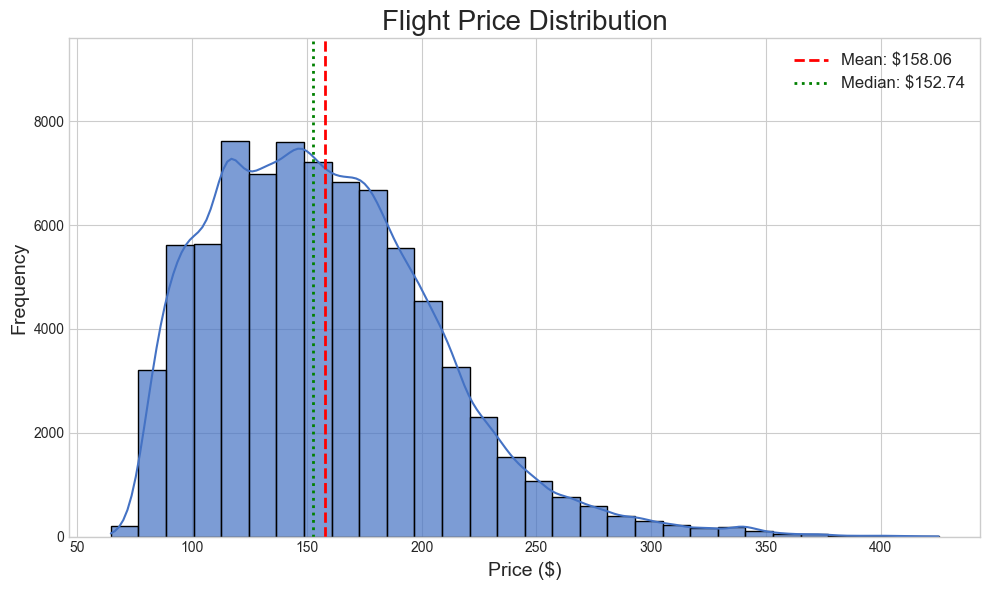

The target variable kurtosis is 1.0734633298304717
The target variable skew is 0.8352127877264993


In [25]:
def TargetCol(data): 
    '''Target column analysis - which in this case is the price column distribution'''
    plt.style.use('seaborn-v0_8-whitegrid')

    plt.figure(figsize=(10, 6))
    plt.title('Flight Price Distribution', fontsize=20)

    sns.histplot(data['price'], bins=30, kde=True, color='#4472C4', 
                edgecolor='black', alpha=0.7)

    mean_price = data['price'].mean()
    median_price = data['price'].median()
    plt.axvline(mean_price, color='red', linestyle='--', linewidth=2, 
                label=f'Mean: ${mean_price:.2f}')
    plt.axvline(median_price, color='green', linestyle=':', linewidth=2, 
                label=f'Median: ${median_price:.2f}')

    plt.ylim(0, plt.ylim()[1] * 1.2)

    plt.xlabel('Price ($)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.legend(fontsize=12)

    plt.tight_layout()
    plt.show()

    print(f"The target variable kurtosis is {kurtosis(data['price'])}")
    print(f"The target variable skew is {skew(data['price'])}")
    
TargetCol(data1)

The results of the kurtosis and skew mean that the price target 

In [26]:
data_value_counts = data1['to_dest_company'].value_counts()
data_value_counts = pd.DataFrame(data_value_counts).style.background_gradient("cool")
data_value_counts

,count
to_dest_company,
Vueling,22241
Ryanair,19484
easyJet,19421
Wizz Air Malta,10191
Transavia France,3473
British Airways,1278
ITA Airways,1167
Jet2,877
Wizz Air UK,220


There is A lot of data 

In [31]:
company_mapping = {
    'Wizz Air Malta': 'Wizz Air',
    'Wizz Air UK': 'Wizz Air',
    'Ryanair UK': 'Ryanair',
    'Multiple airlines': 'Other',
    'Scandinavian Airlines': 'SAS',
    'KM Malta Airlines': 'Other',
    'Aeroitalia': 'Other',
    'FlixBus': 'Other',
    'BlaBlaBus': 'Other',
    'Union Ivkoni': 'Other',
    'Brussels Airlines': 'Other',
    'SWISS': 'Other',
    'Volotea': 'Other'
}

data1['to_dest_company'] = data1['to_dest_company'].replace(company_mapping)
data1['return_company'] = data1['return_company'].replace(company_mapping)

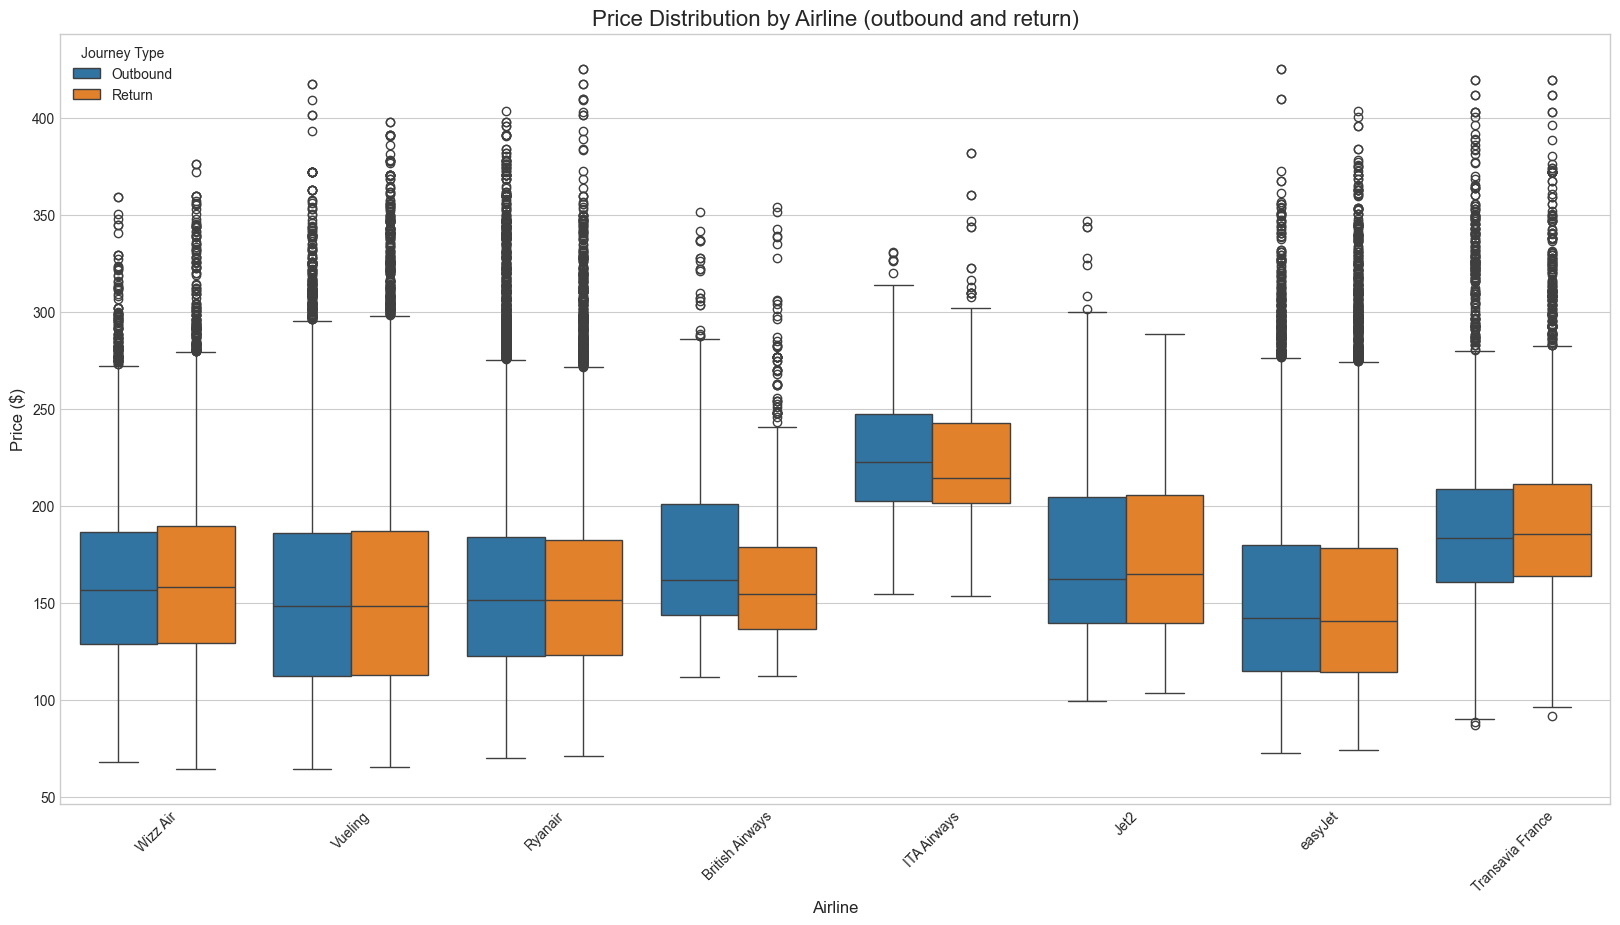

In [32]:
def price_per_airline(data):
    '''visualize dist of price per airway company (outbound and return)'''
    
    plt.figure(figsize=(20, 10))

    outbound_data = data[['price', 'to_dest_company']].copy()
    outbound_data['journey_type'] = 'Outbound'
    outbound_data.rename(columns={'to_dest_company': 'company'}, inplace=True)

    return_data = data[['price', 'return_company']].copy()
    return_data['journey_type'] = 'Return'
    return_data.rename(columns={'return_company': 'company'}, inplace=True)

    combined_data = pd.concat([outbound_data, return_data])

    # Get the top 10 most frequent airlines
    top_airlines = combined_data['company'].value_counts().nlargest(8).index.tolist()
    combined_data_filtered = combined_data[combined_data['company'].isin(top_airlines)]

    sns.boxplot(x='company', y='price', hue='journey_type', data=combined_data_filtered)
    plt.xlabel('Airline', fontsize=12)
    plt.ylabel('Price ($)', fontsize=12)
    plt.title('Price Distribution by Airline (outbound and return)', fontsize=16)
    plt.xticks(rotation=45)
    plt.legend(title='Journey Type')

price_per_airline(data1)

Although the original requirement focused on prices by operating company, we further split the analysis into outbound and return flights to better understand pricing patterns across the full travel experience.

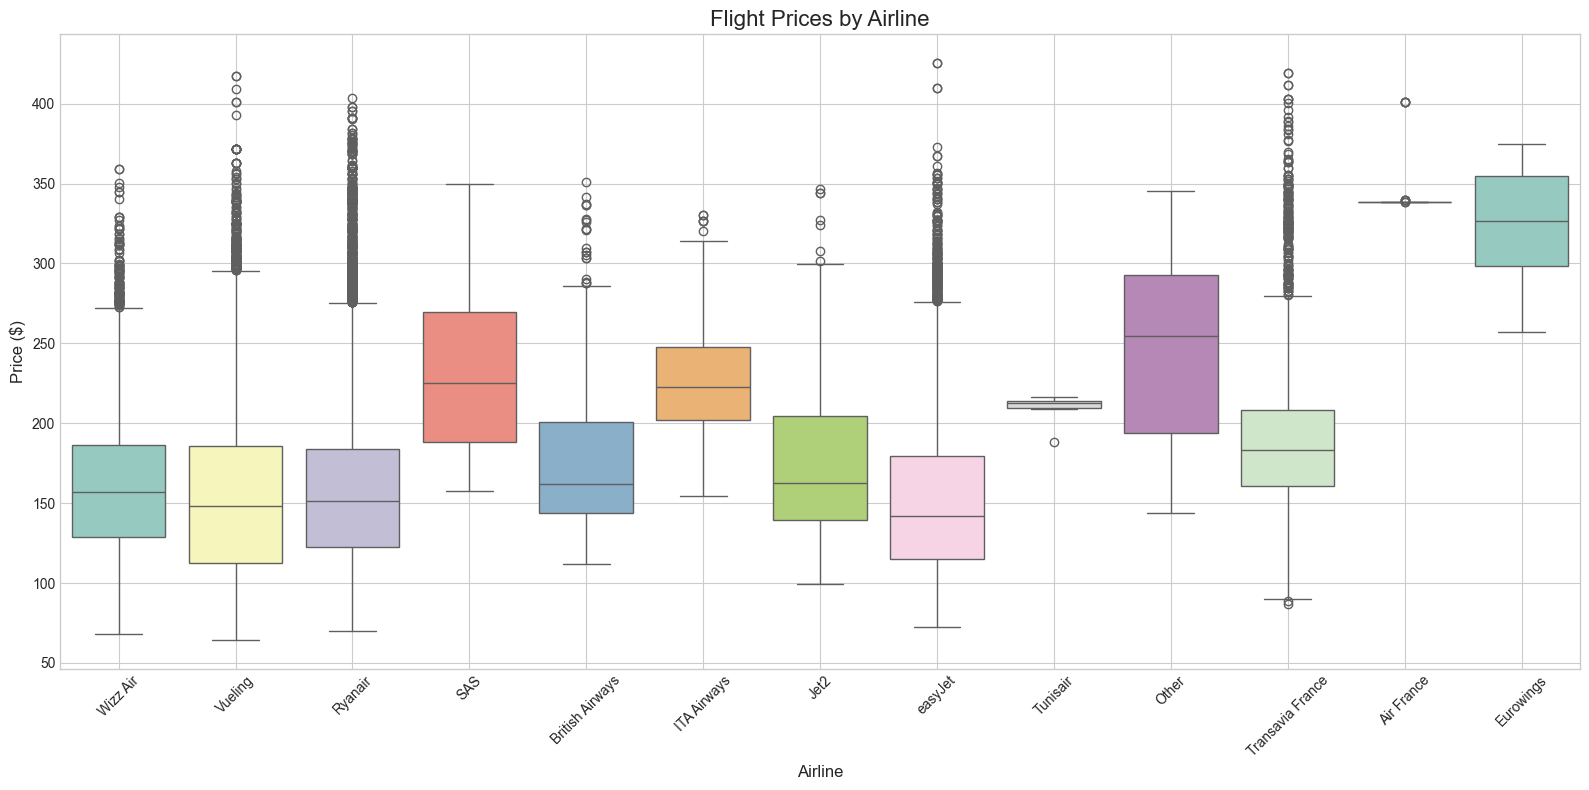

In [44]:
plt.figure(figsize=(16, 8))

sns.boxplot(
    data=data1,
    x='to_dest_company',
    y='price',
    hue='to_dest_company',  
    palette='Set3',
    legend=False           
)

plt.xticks(rotation=45)
plt.title('Flight Prices by Airline', fontsize=16)
plt.xlabel('Airline', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:

top_airlines = data1['to_dest_company'].value_counts().nlargest(8).index
filtered_data = data1[data1['to_dest_company'].isin(top_airlines)]

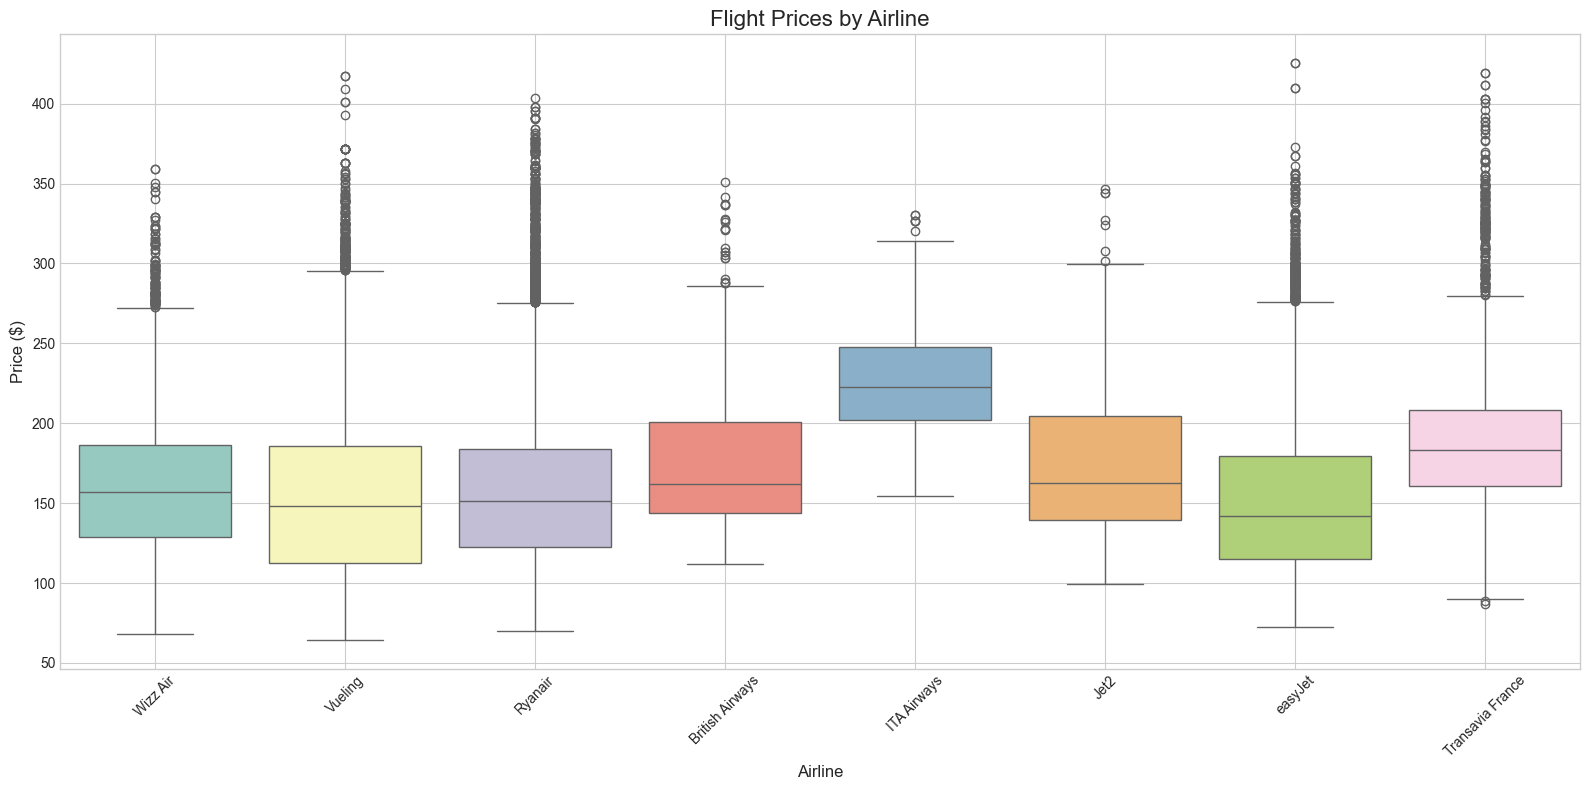

In [45]:
plt.figure(figsize=(16, 8))
sns.set_style("whitegrid")

sns.boxplot(
    data=filtered_data,
    x='to_dest_company',
    y='price',
    hue='to_dest_company',  
    palette='Set3',
    legend=False          
)

plt.xticks(rotation=45)
plt.title('Flight Prices by Airline', fontsize=16)
plt.xlabel('Airline', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.tight_layout()
plt.grid(True)
plt.show()


now lets visualize the price per city (origin, destination anf total route)

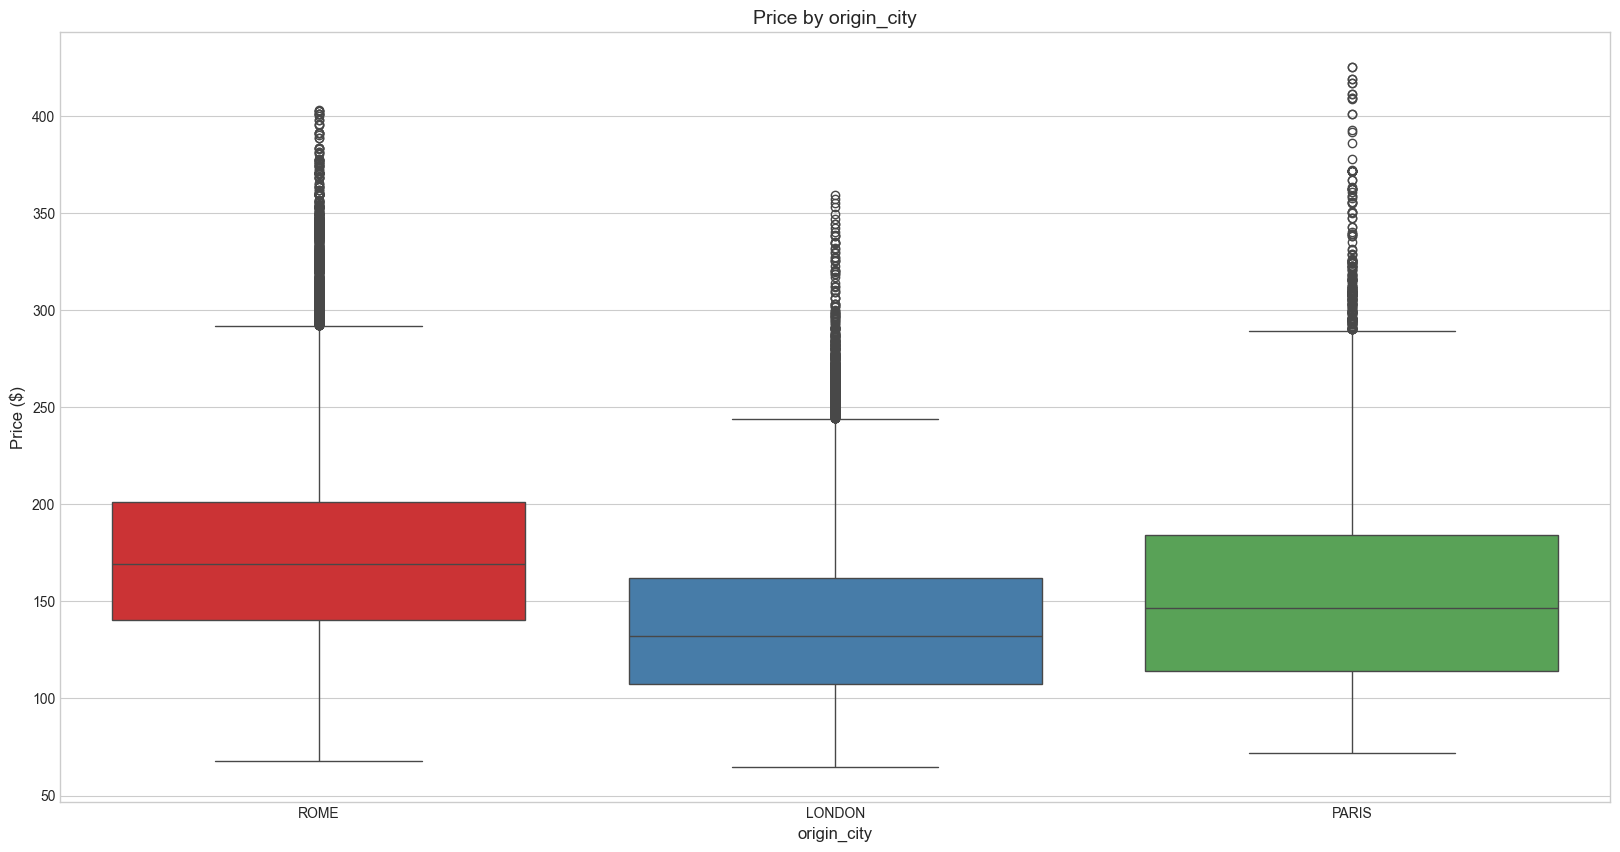

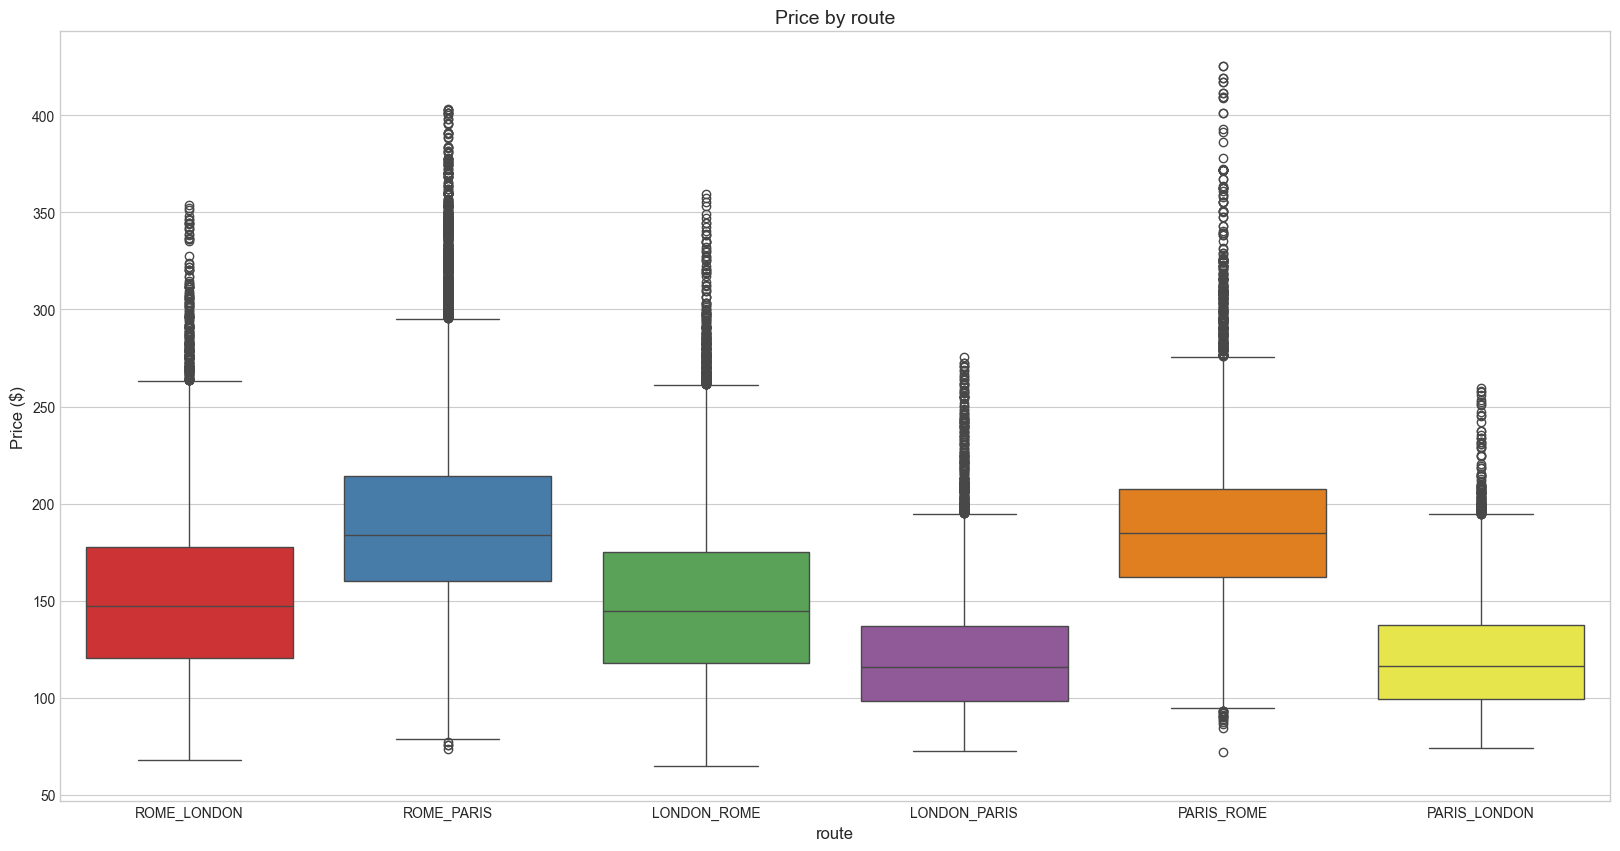

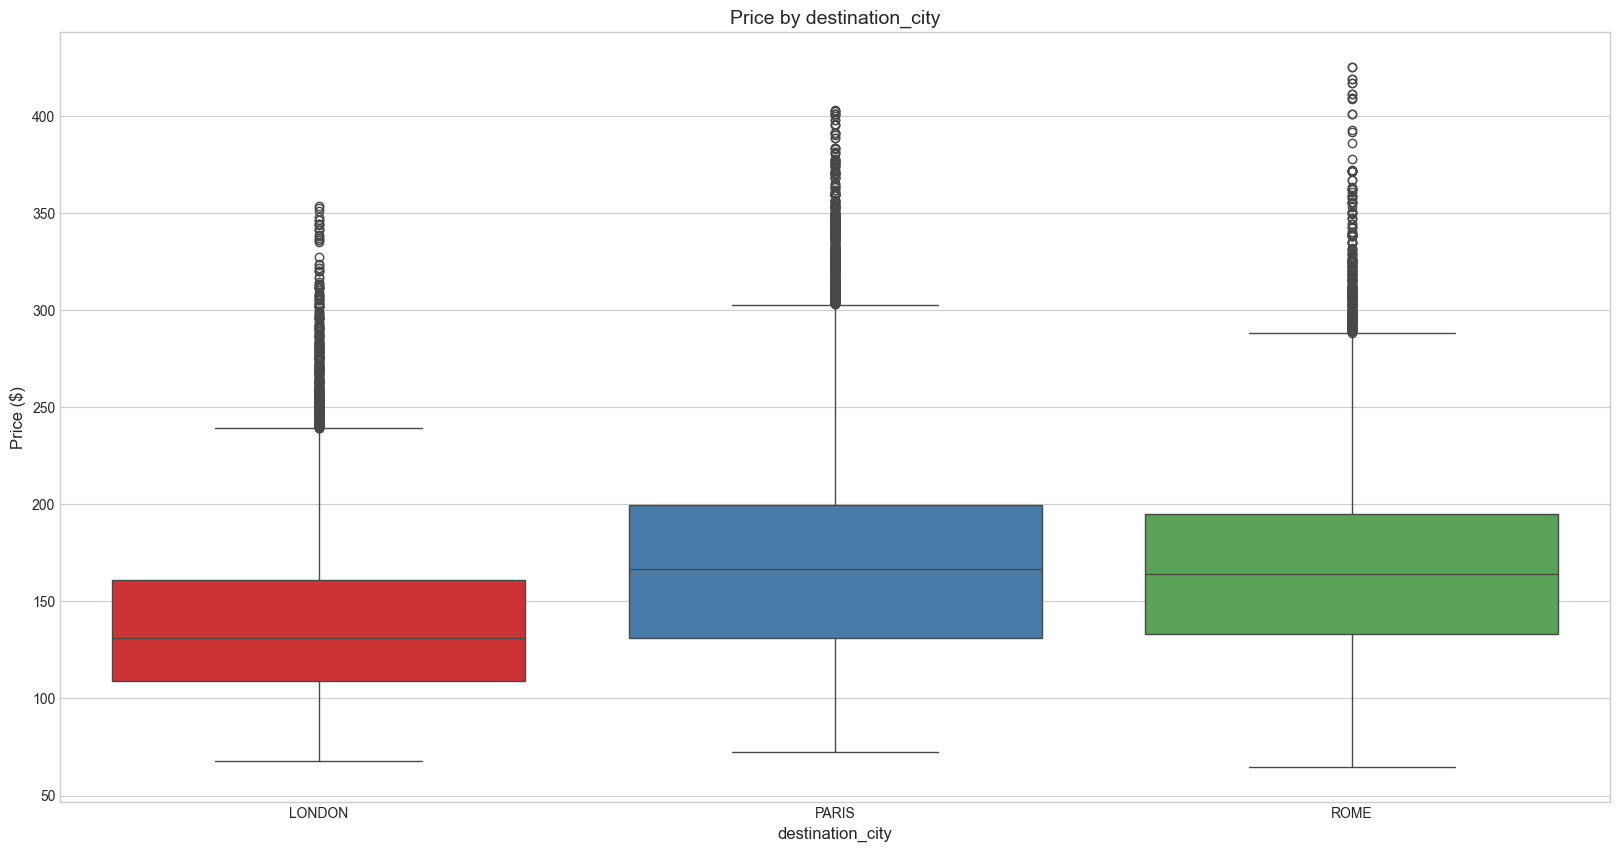

In [39]:
def price_per_feature(data, column: str):
    plt.figure(figsize=(20, 10))
    top_routes = data[column].value_counts().index.tolist()
    cities_data = data[data[column].isin(top_routes)]

    sns.boxplot(x=column, y='price', data=cities_data, hue=column, palette='Set1', legend=False)
    plt.title(f'Price by {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Price ($)', fontsize=12)
    
price_per_feature(data1, 'origin_city')
price_per_feature(data1, 'route')
price_per_feature(data1, 'destination_city')

# Insights 

## Price by origin_city -
Flights departing from Rome are generally more expensive than those from London. Paris sits in the middle in terms of median price but has a wide spread, indicating possible fluctuations depending on the route.

## Price by route - 
Routes connecting Rome and Paris exhibit significantly higher ticket prices and variability, while routes between London and Paris are generally cheaper and more consistent. This suggests greater demand or fewer flights on Rome–Paris legs.

## Price by destination_city - 
Flights destined to Paris tend to be more expensive and more variable in price compared to London, which consistently shows lower and more stable pricing. Rome lies in between, with moderate median price and variance.


### let check out the companies 

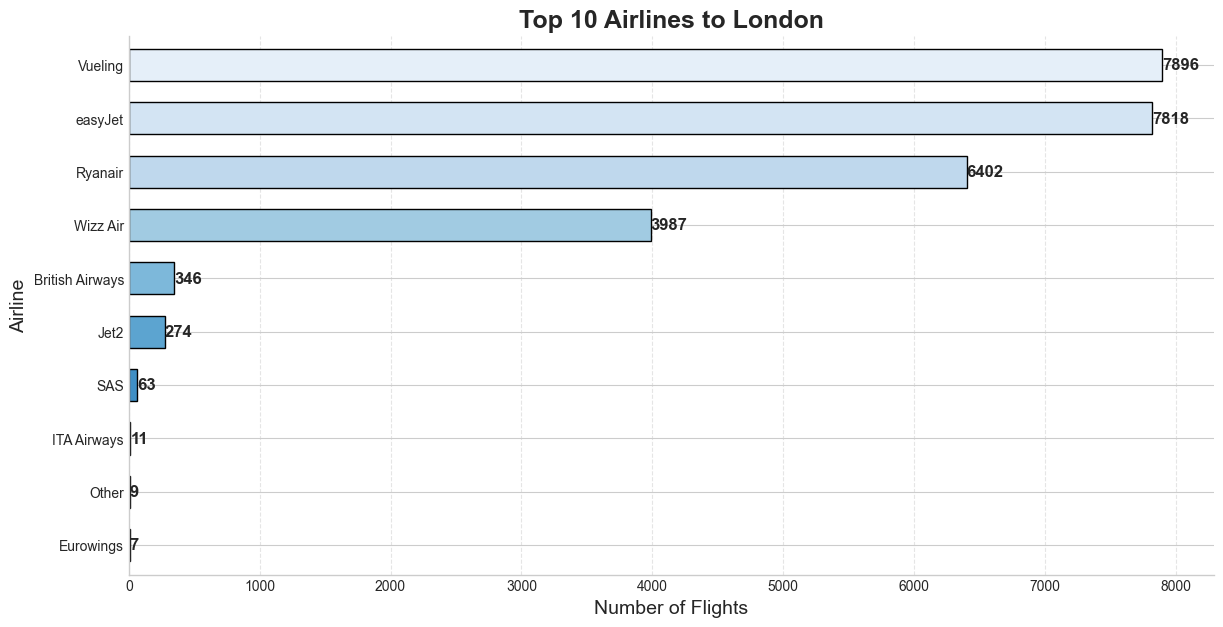

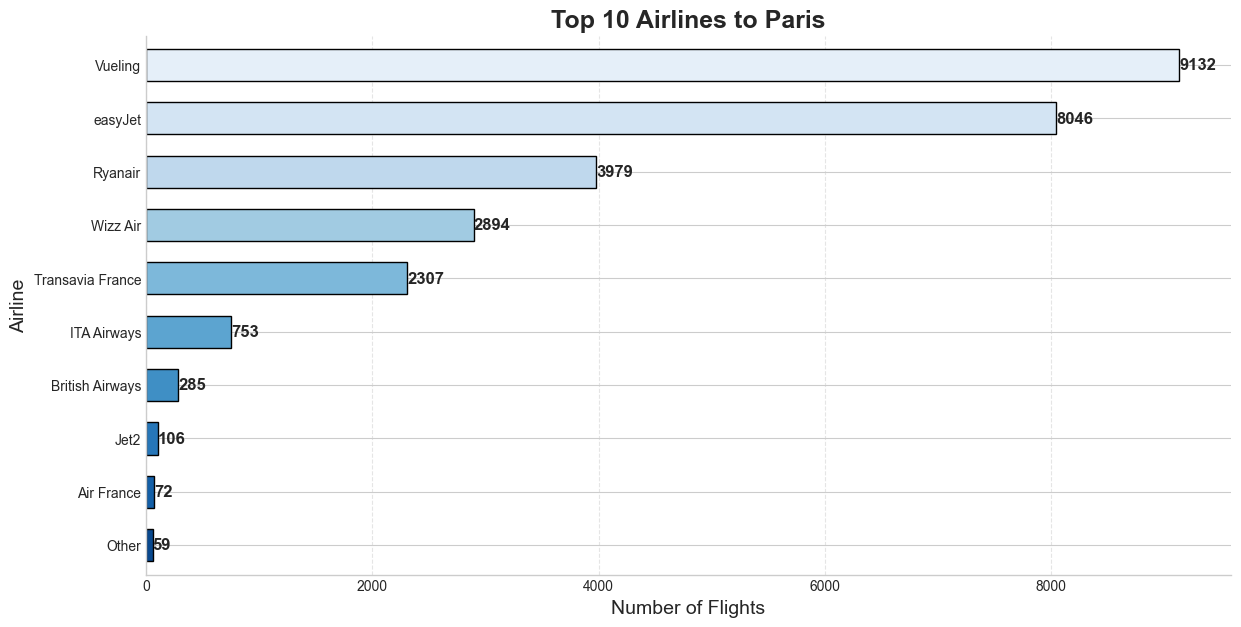

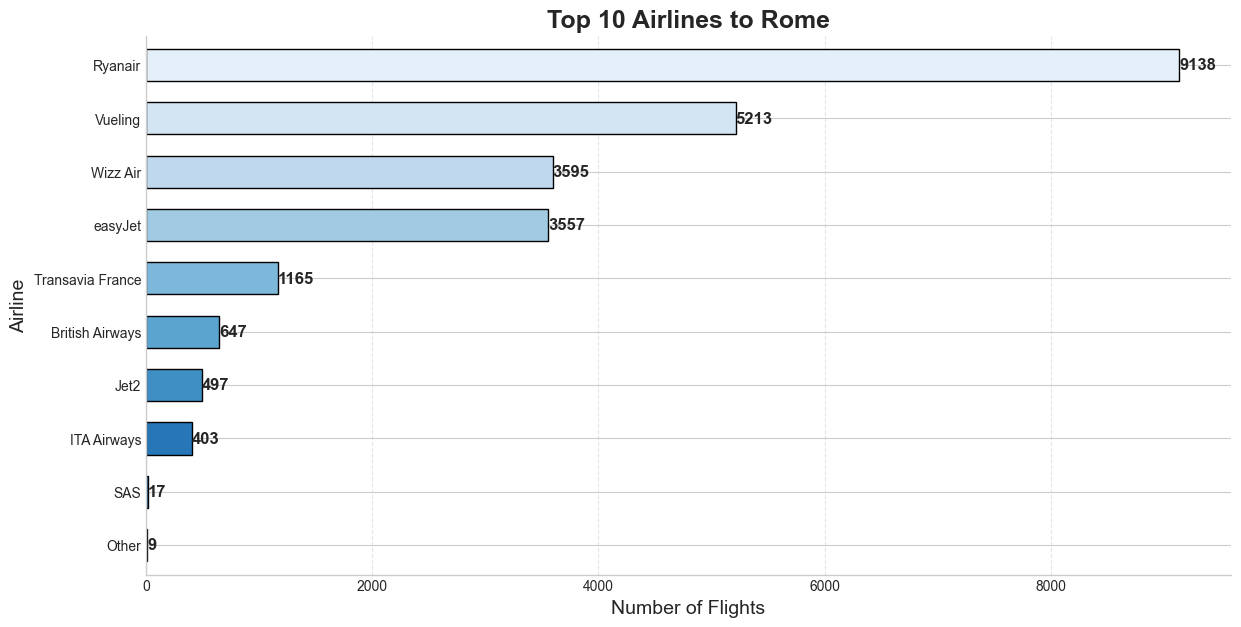

In [46]:
# Set seaborn style for better visualization
sns.set_style("whitegrid")

def top_airlines_per_city(data):
    flight_counts = data.groupby(["destination_city", "to_dest_company"]).size().unstack().fillna(0)

    # Get the top 5 airlines with the most flights for each destination
    london_flights = flight_counts.loc["LONDON"].nlargest(10)
    paris_flights = flight_counts.loc["PARIS"].nlargest(10)
    rome_flights = flight_counts.loc["ROME"].nlargest(10)

    # Plot the results
    flights_counts(london_flights, "London")
    flights_counts(paris_flights, "Paris")
    flights_counts(rome_flights, "Rome")

def flights_counts(dest_flight_counts, dest):
    fig, ax = plt.subplots(figsize=(14, 7))

    # Plot sorted bar chart
    bars = dest_flight_counts.sort_values(ascending=True).plot(
        kind="barh", 
        ax=ax, 
        edgecolor="black", 
        width=0.6,  # Reduce bar spacing
        color=sns.color_palette("Blues_r", len(dest_flight_counts))
    )

    # Improve aesthetics
    ax.set_title(f"Top 10 Airlines to {dest}", fontsize=18, fontweight="bold")
    ax.set_xlabel("Number of Flights", fontsize=14)
    ax.set_ylabel("Airline", fontsize=14)
    ax.grid(axis="x", linestyle="--", alpha=0.5)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    # Add value labels
    for bar in bars.patches:
        ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
                f'{int(bar.get_width())}', 
                ha='left', va='center', fontsize=12, fontweight="bold")

    plt.show()

# Call the function
top_airlines_per_city(data1)


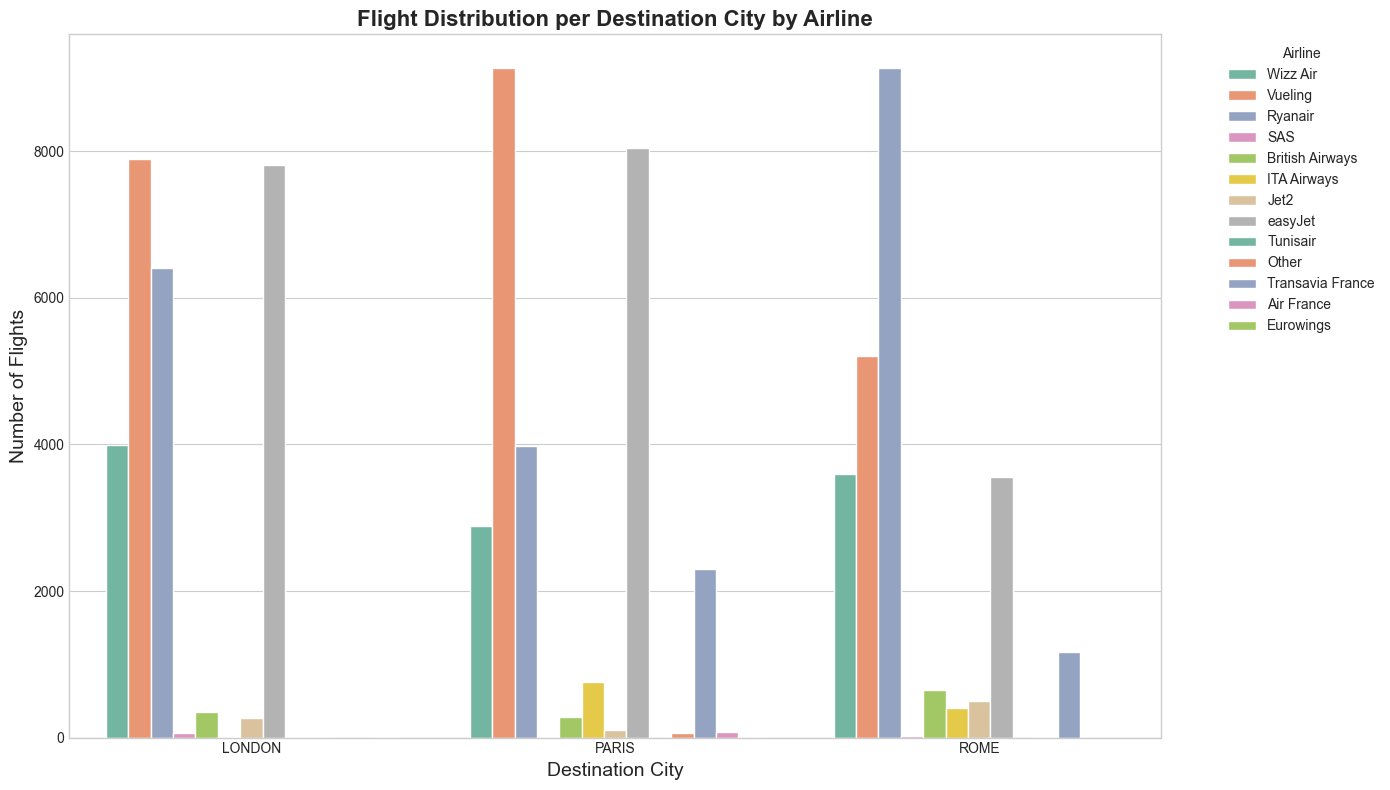

In [47]:
plt.figure(figsize=(14, 8))
sns.countplot(
    x='destination_city',
    hue='to_dest_company',  
    data=data1,
    palette='Set2'
)

plt.title("Flight Distribution per Destination City by Airline", fontsize=16, fontweight='bold')
plt.xlabel("Destination City", fontsize=14)
plt.ylabel("Number of Flights", fontsize=14)
plt.legend(title="Airline", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Insights

- **Paris**: Dominated by **easyJet** and **Other** airlines. Vueling and Ryanair are active but with lower volume.
- **London**: Led by **Vueling**, **easyJet**, and **Other**. Ryanair is present but not dominant.
- **Rome**: Clearly led by **Ryanair**, followed by **easyJet** and Other. Airline presence is more balanced here.

 Overall, **easyJet** appears to be the most active airline across all three destinations.  
 **Ryanair** dominates in Rome, while **Paris** and **London** are more influenced by Vueling and easyJet.

destination

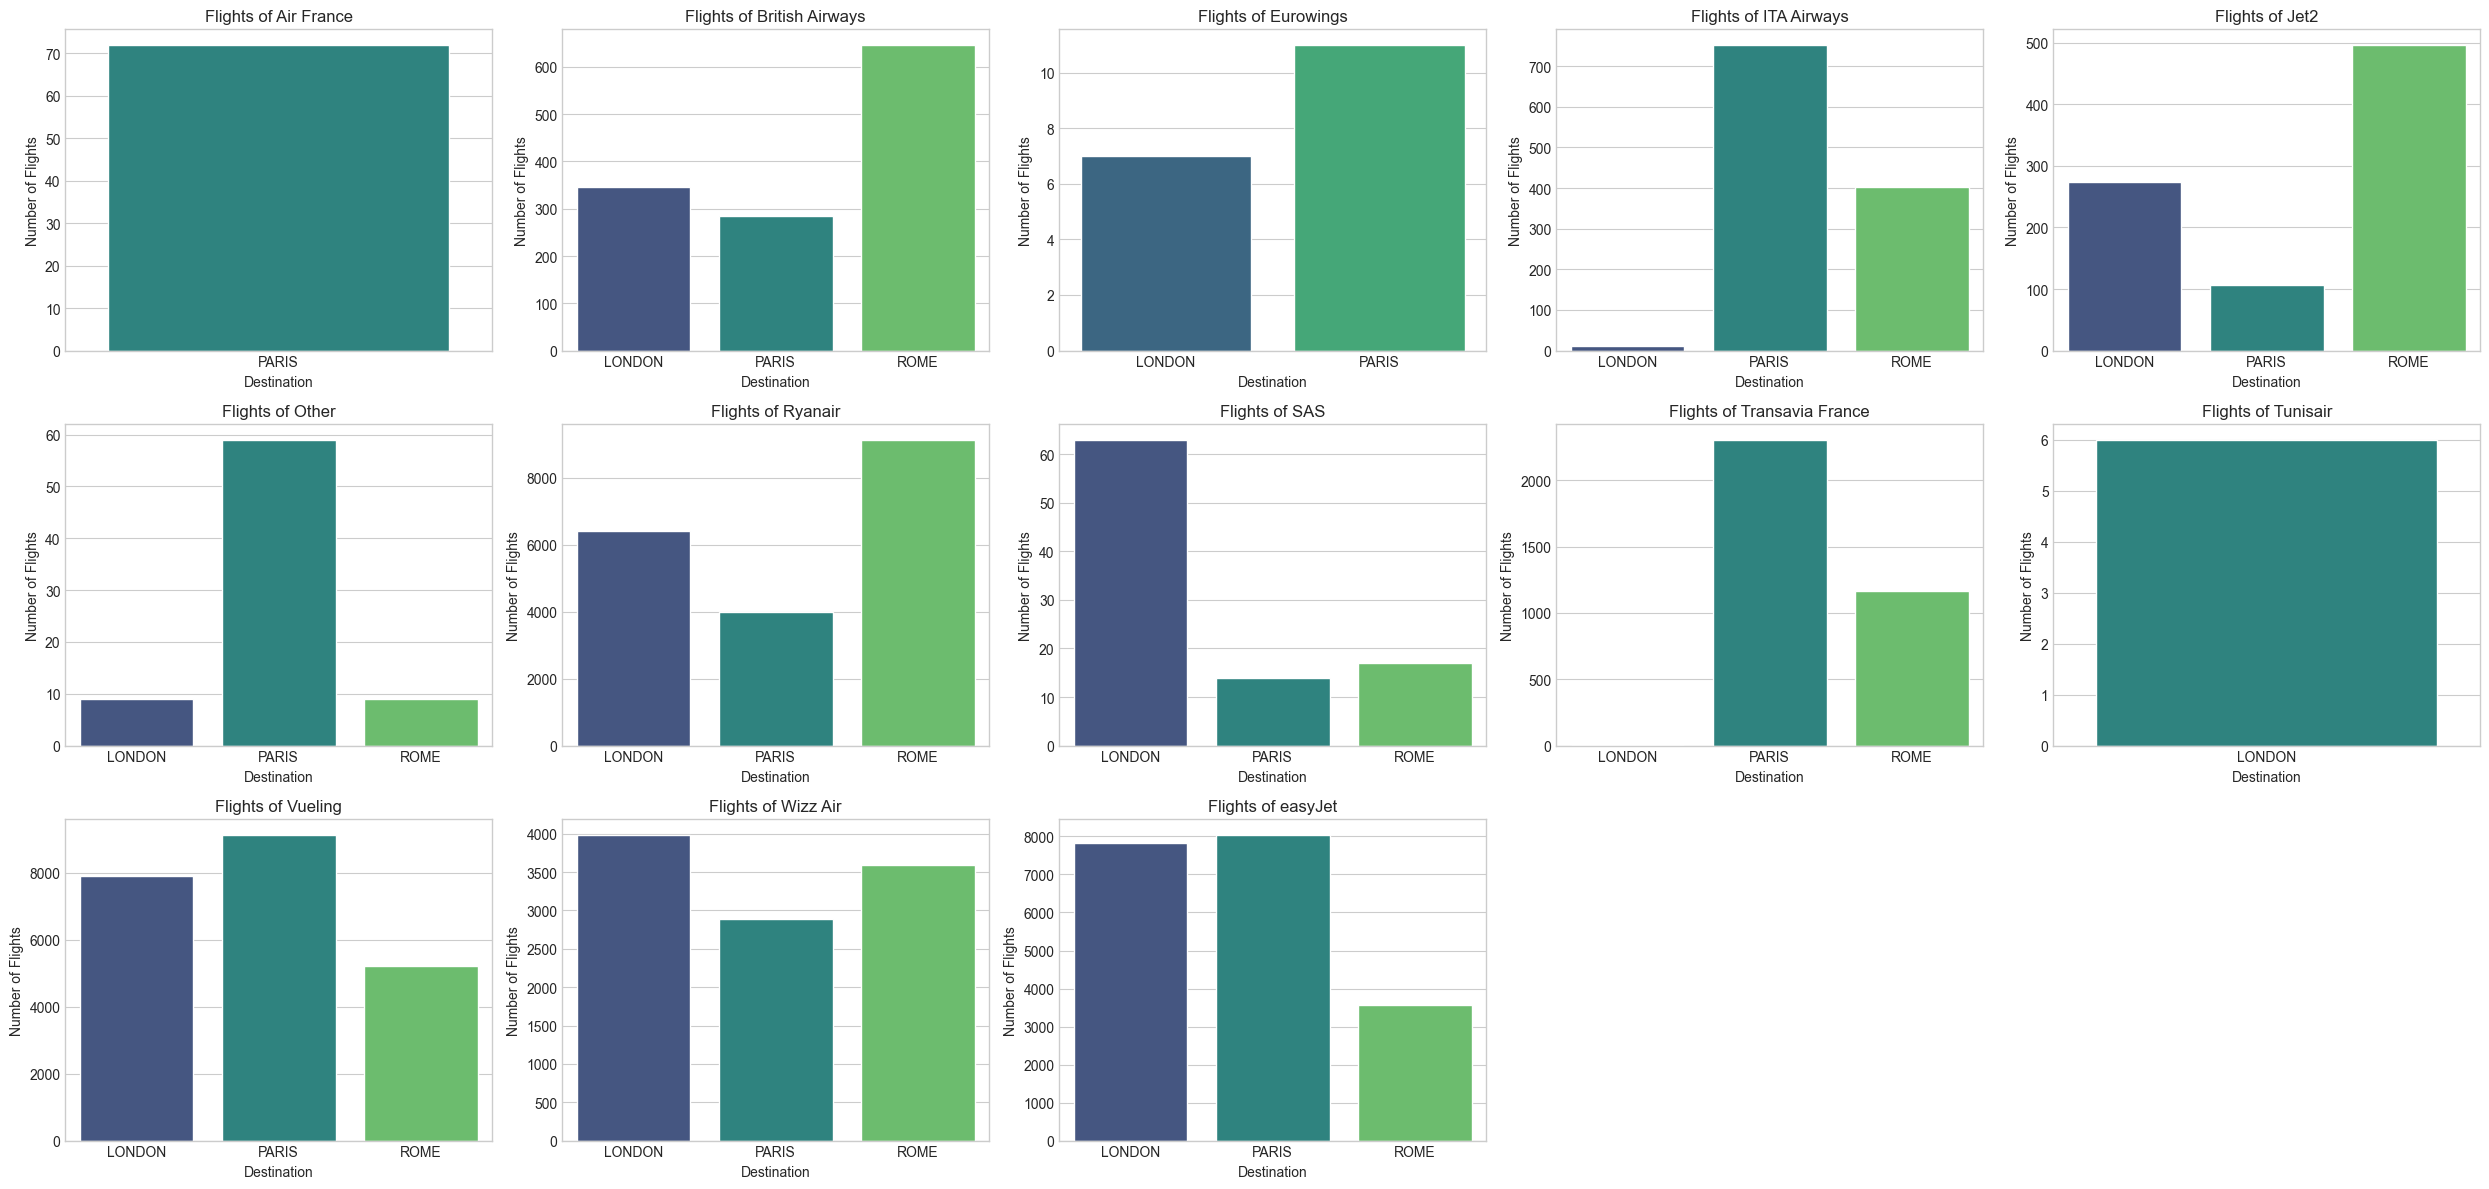

In [49]:
def flights_per_company(data):
    # Group data by flight company and destination, then count flights
    flight_counts = data.groupby(['to_dest_company', 'destination_city']).size().reset_index(name='count')

    # Get unique airlines
    airlines = flight_counts['to_dest_company'].unique()
    num_airlines = len(airlines)
    num_rows = int(np.ceil(num_airlines / 5))

    # Create subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=5, figsize=(25, 4 * num_rows))
    axes = axes.flatten()

    # Plot barplot for each airline
    for i, airline in enumerate(airlines):
        subset = flight_counts.loc[flight_counts['to_dest_company'] == airline].copy()
        # Explicitly group the subset by destination city
        grouped_subset = subset.groupby('destination_city')['count'].sum().reset_index()
        sns.barplot(
            x='destination_city',
            y='count',
            hue='destination_city',          
            data=grouped_subset,
            palette='viridis',
            dodge=False,
            ax=axes[i]
        )
        axes[i].set_title(f'Flights of {airline}')
        axes[i].set_xlabel('Destination')
        axes[i].set_ylabel('Number of Flights')
         

    # Hide extra subplots
    for i in range(len(airlines), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

flights_per_company(data1)

origin

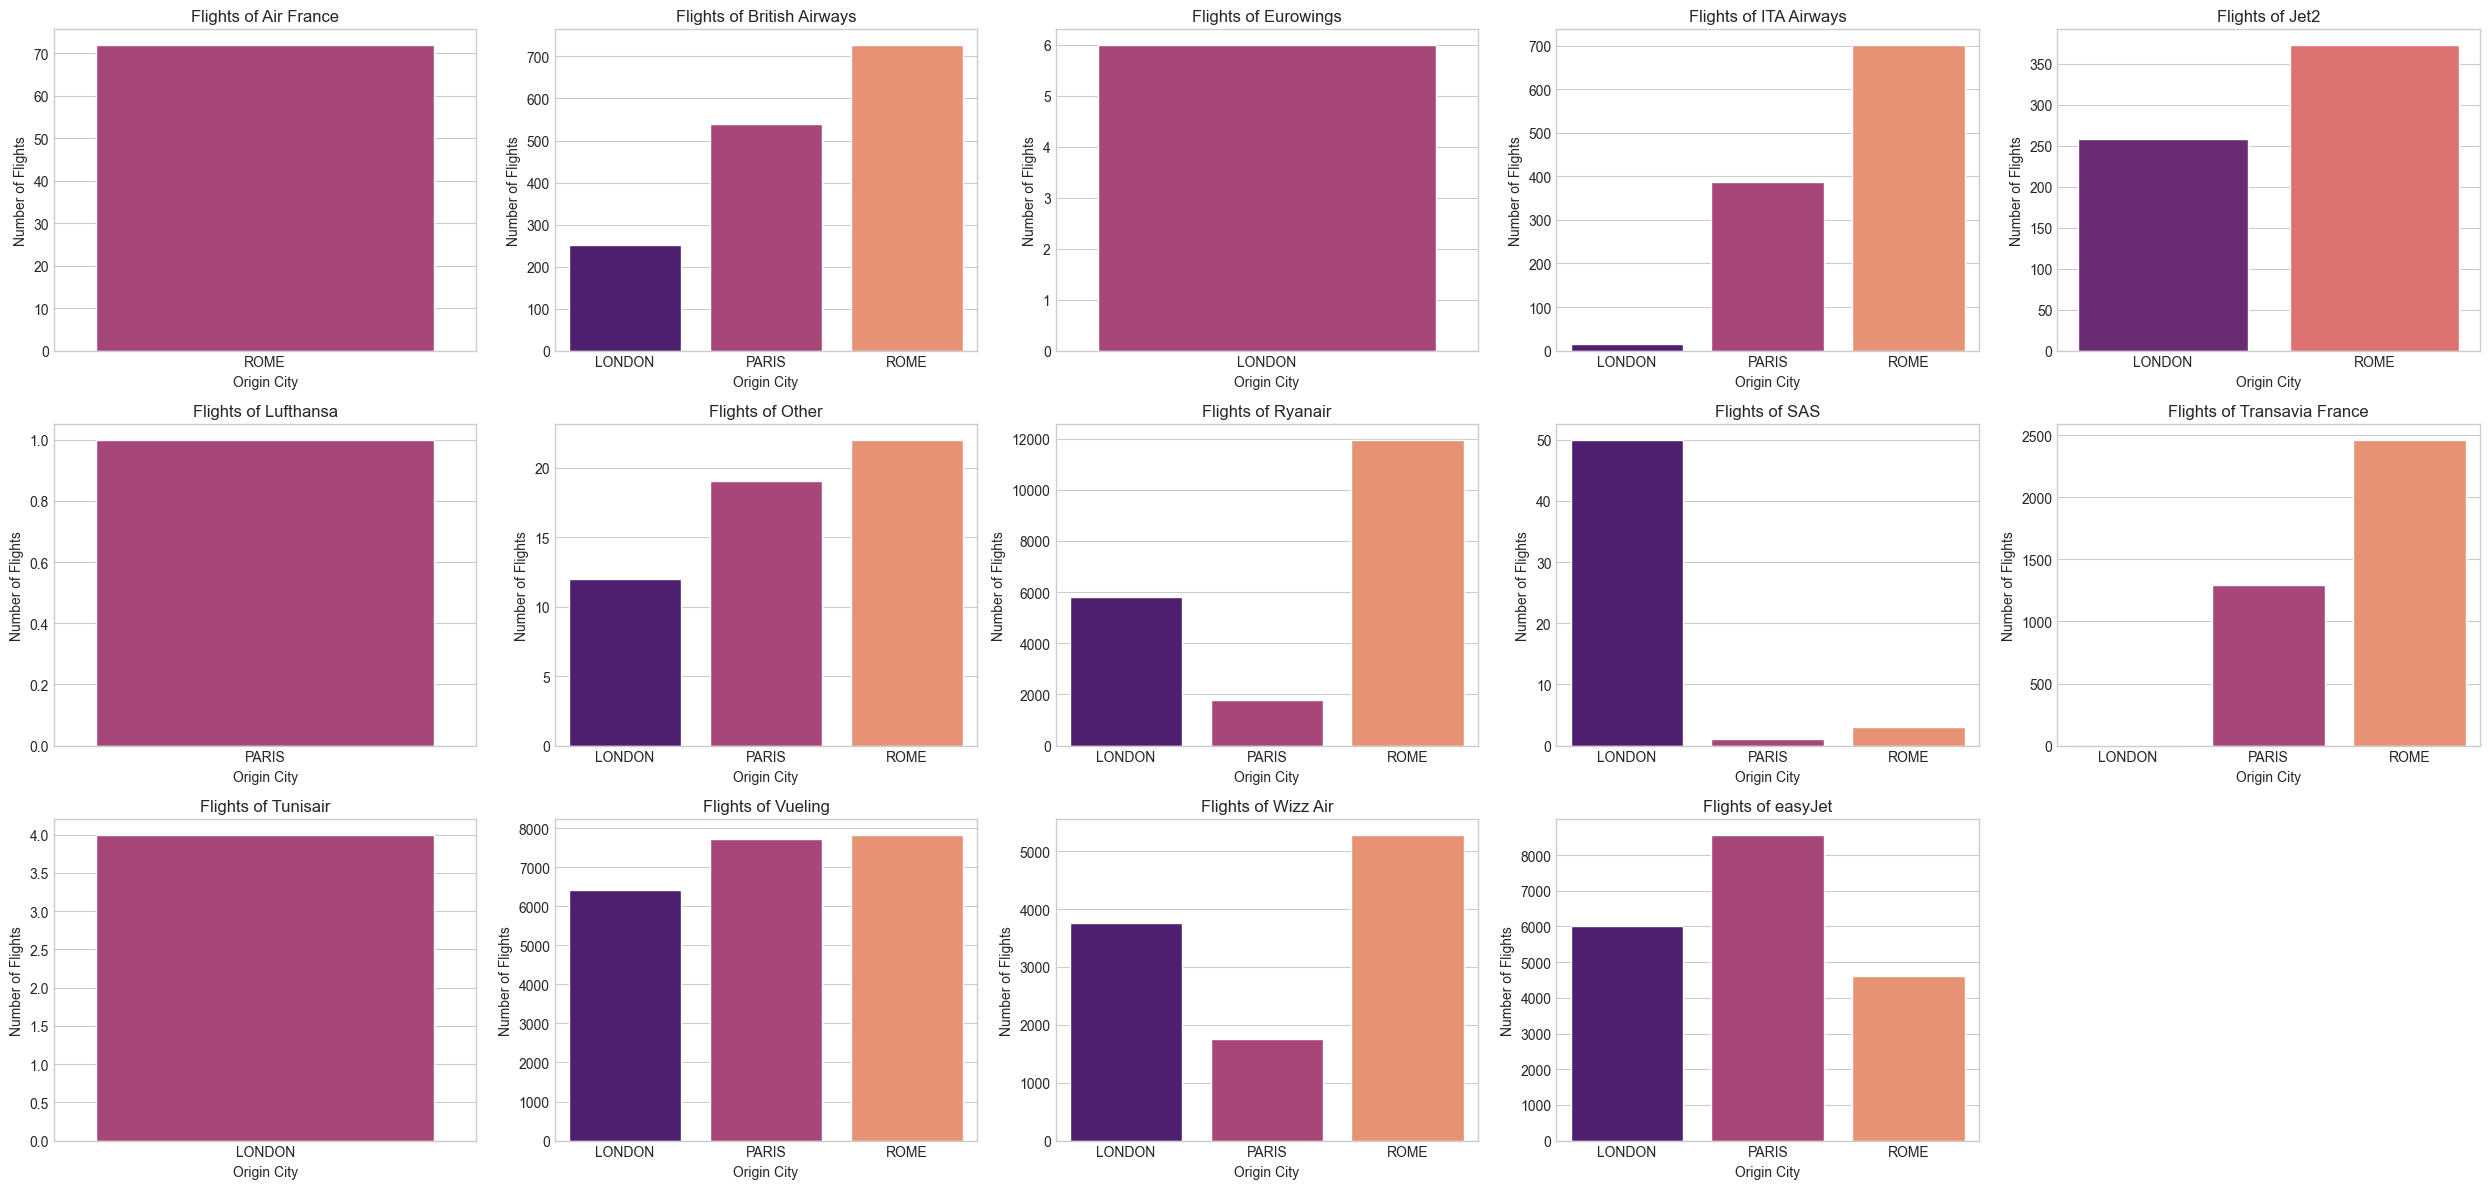

In [50]:
def flight_by_origin_city(data):
    # Group data by flight company and origin city, then count flights
    flight_counts = data.groupby(['return_company', 'origin_city']).size().reset_index(name='count')

    # Get unique airlines
    airlines = flight_counts['return_company'].unique()
    num_airlines = len(airlines)
    num_rows = int(np.ceil(num_airlines / 5))

    # Create subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=5, figsize=(25, 4 * num_rows))
    axes = axes.flatten()

    # Plot barplot for each airline
    for i, airline in enumerate(airlines):
        subset = flight_counts.loc[flight_counts['return_company'] == airline].copy()
        grouped_subset = subset.groupby('origin_city')['count'].sum().reset_index()
        sns.barplot(
            x='origin_city',
            y='count',
            hue='origin_city',         
            dodge=False,               
            data=grouped_subset,
            ax=axes[i],
            palette='magma'
        )
        axes[i].set_title(f'Flights of {airline}')
        axes[i].set_xlabel('Origin City')
        axes[i].set_ylabel('Number of Flights')
        

    # Hide extra subplots
    for i in range(len(airlines), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

flight_by_origin_city(data1)

### Flights Distribution by Origin and Destination City (Kiwi)

#### Flights by Origin City:
- **Rome (ROME)** is the most common **origin city** among most airlines.
- **London** and **Paris** also appear, but with lower frequencies.
- Some airlines operate **only from one city**, such as Lufthansa and Tunisair.

#### Flights by Destination City:
- **London** and **Paris** are the **most frequent destination cities**.
- **Rome** is also a destination for several airlines, but with slightly lower volume.
- There are **notable differences** between airlines – some focus on a single destination, others split flights across multiple cities.

#### Key Insights:
- The majority of Kiwi flights operate between **ROME ↔ LONDON/PARIS**, suggesting high demand or profitability on these routes.
- Some airlines show **route specialization**, focusing on fixed, high-frequency city pairs.


### Layovers

#### outbound layover

C:\Users\LaurenM\AppData\Local\Temp\ipykernel_18092\2311178184.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


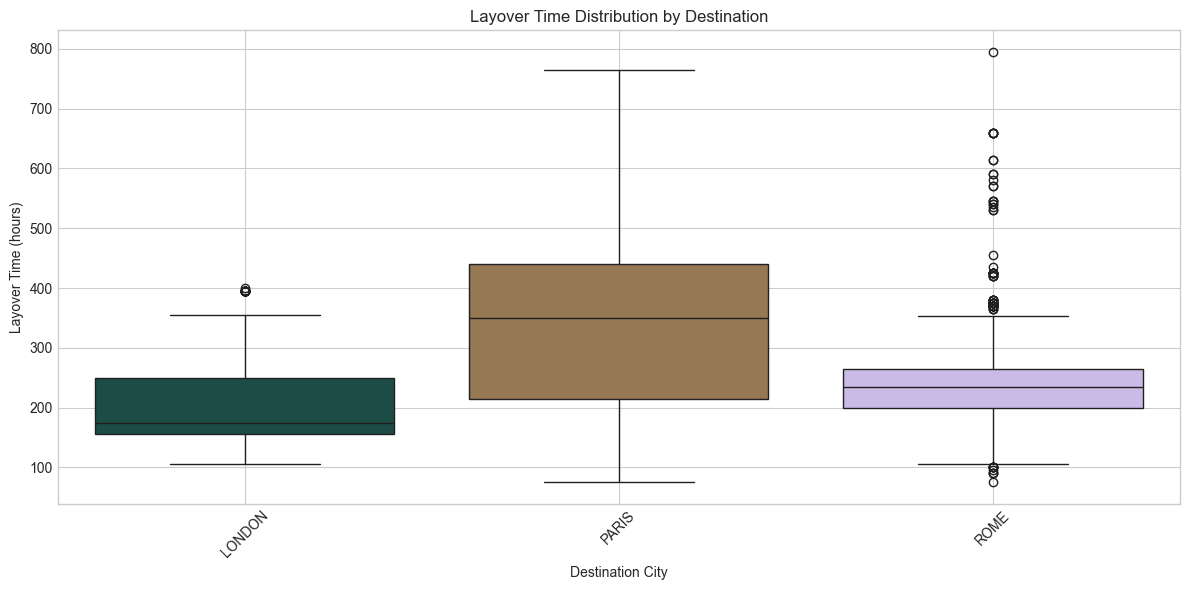

,Mean Layover,Median Layover,Min Layover,Max Layover,Layover Std Dev
destination_city,,,,,
LONDON,210.49,175.0,105,400,75.57
PARIS,342.90,350.0,75,765,156.70
ROME,247.56,235.0,75,795,85.64


In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_layover_time(data):
    layover_data = data[(data['layover'] == True) & (data['layover_time'] > 0)]

    plt.figure(figsize=(12, 6))
    sns.boxplot(
        x='destination_city',
        y='layover_time',
        data=layover_data,
        palette='cubehelix',
        hue=None  
    )
    plt.title('Layover Time Distribution by Destination')
    plt.xlabel('Destination City')
    plt.ylabel('Layover Time (hours)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def group_destcity_layovertime(data):
    summary = (
        data[data['layover_time'] > 0]
        .groupby('destination_city')['layover_time']
        .agg([
            ('Mean Layover', 'mean'),
            ('Median Layover', 'median'),
            ('Min Layover', 'min'),
            ('Max Layover', 'max'),
            ('Layover Std Dev', 'std')
        ])
        .round(2)
    )
    display(summary)

def layover_time(data):
    plot_layover_time(data)
    group_destcity_layovertime(data)

# הפעלת הפונקציה
layover_time(data1)


if there is a layover, price dist over time of layover per dest

C:\Users\LaurenM\AppData\Local\Temp\ipykernel_18092\4042932374.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='destination_city', y='return_layover_time', data=layover_data, palette='icefire')


,Mean Layover,Median Layover,Min Layover,Max Layover,Layover Std Dev
destination_city,,,,,
LONDON,6.37,0.0,0,570,38.93
PARIS,7.25,0.0,0,660,43.62
ROME,5.93,0.0,0,765,43.89


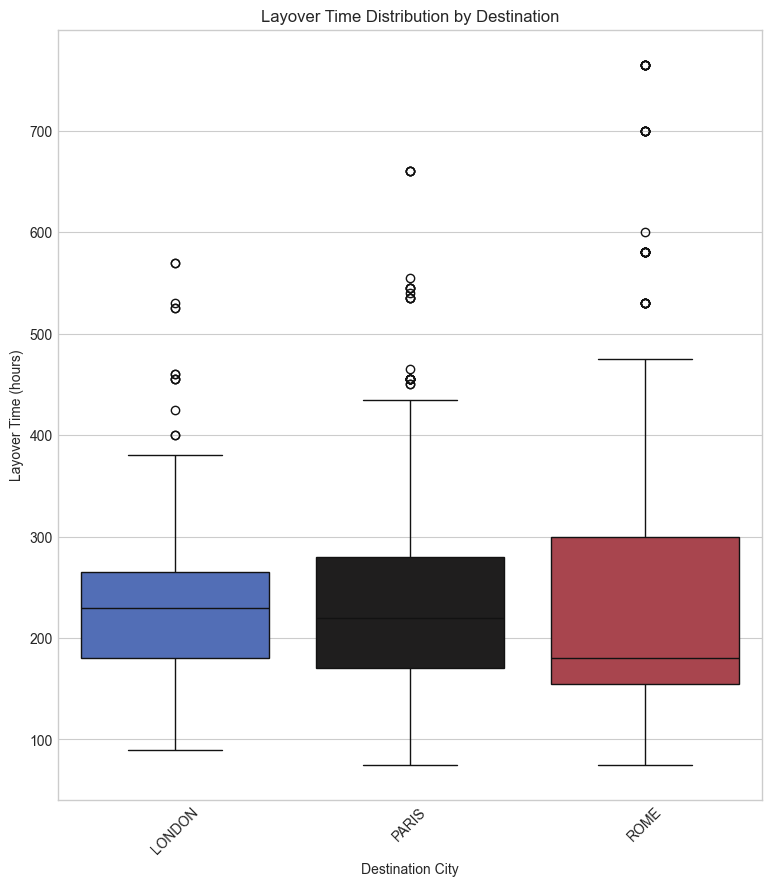

In [53]:
def plot_layover_return_time(data):
    layover_data = data[data['layover']== True]
    layover_data = layover_data[layover_data['return_layover_time'] > 0]
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 2, 1)
    sns.boxplot(x='destination_city', y='return_layover_time', data=layover_data, palette='icefire')
    plt.title('Layover Time Distribution by Destination')
    plt.xlabel('Destination City')
    plt.ylabel('Layover Time (hours)')
    plt.xticks(rotation=45)


def group_destcity_return_layovertime(data):
    # Calculate summary statistics
    display(data.groupby('destination_city')['return_layover_time'].agg([
        ('Mean Layover', 'mean'),
        ('Median Layover', 'median'),
        ('Min Layover', 'min'),
        ('Max Layover', 'max'),
        ('Layover Std Dev', 'std')
    ]).round(2))

def return_layover_time(data):
    plot_layover_return_time(data)
    group_destcity_return_layovertime(data)
    
return_layover_time(data1)

departure airport per city price influance

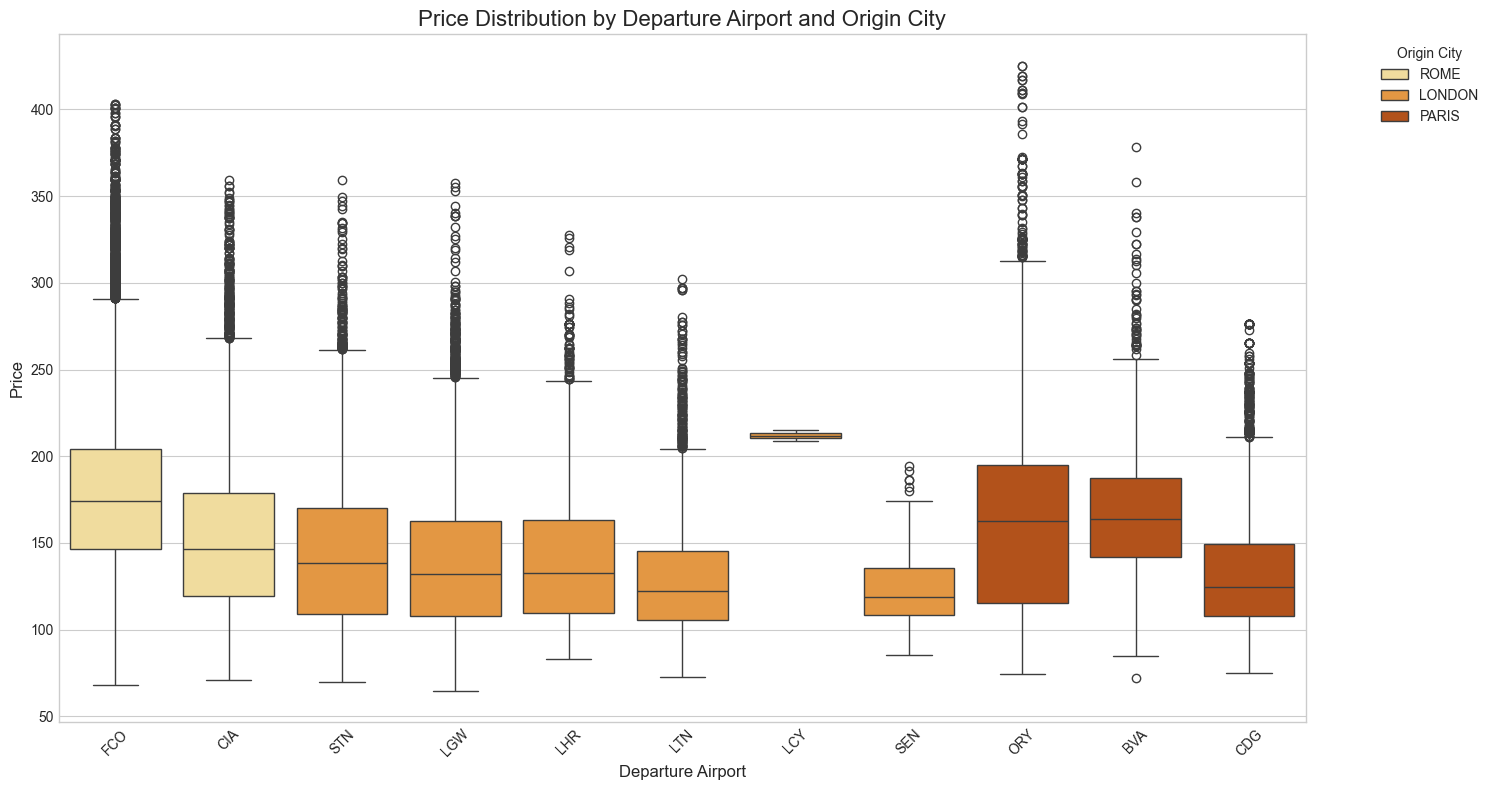

In [54]:
def price_per_deptair_origcity(data):
    plt.figure(figsize=(15, 8))
        
    # Create a box plot to show price distribution by departure airport for each origin city
    sns.boxplot(x='departure_airport', y='price', hue='origin_city', data=data ,palette='YlOrBr')

    plt.title('Price Distribution by Departure Airport and Origin City', fontsize=16)
    plt.xlabel('Departure Airport', fontsize=12)
    plt.ylabel('Price', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Origin City', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()

def group_origincity_deptairport(data):
    # Calculate summary statistics
    data.groupby(['origin_city', 'departure_airport'])['price'].agg([
        ('Mean Price', 'mean'),
        ('Median Price', 'median'),
        ('Min Price', 'min'),
        ('Max Price', 'max'),
        ('Price Std Dev', 'std'),
        ('Number of Flights', 'count')
    ]).round(2)

price_per_deptair_origcity(data1)
group_origincity_deptairport(data1)

C:\Users\LaurenM\AppData\Local\Temp\ipykernel_18092\1155914605.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='time_category', y='price', data=data1, palette='cubehelix')


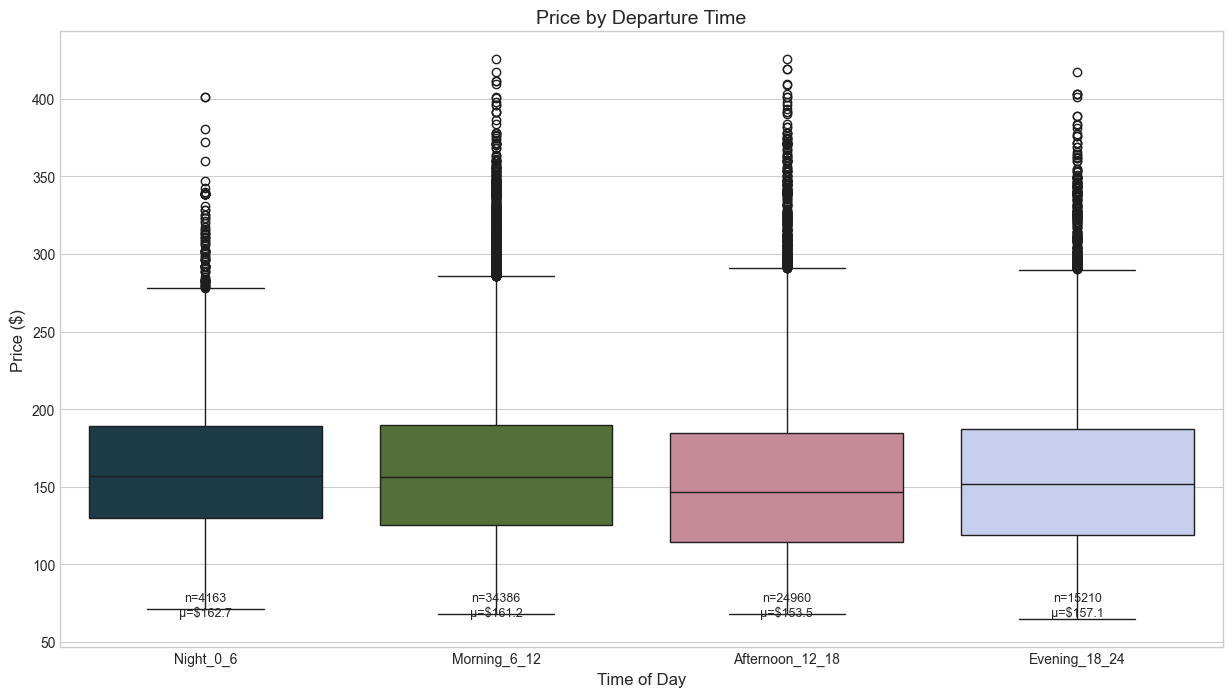

In [55]:
plt.figure(figsize=(15, 8))

# Create time categories
data1['time_category'] = pd.cut(
    data1['departure_hour'], 
    bins=[0, 6, 12, 18, 24],
    labels=['Night_0_6', 'Morning_6_12', 'Afternoon_12_18', 'Evening_18_24']
)

sns.boxplot(x='time_category', y='price', data=data1, palette='cubehelix')
plt.title('Price by Departure Time', fontsize=14)
plt.xlabel('Time of Day', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)

# Add count and mean annotations
for i, category in enumerate(data1['time_category'].cat.categories):
    count = data1[data1['time_category'] == category].shape[0]
    mean = data1[data1['time_category'] == category]['price'].mean()
    plt.annotate(f'n={count}\nμ=${mean:.1f}', 
                        xy=(i, data1['price'].min()), 
                        ha='center', va='bottom', fontsize=9)

##  Findings – Flight Price by Departure Time (Updated)

- **Afternoon (12:00–18:00)** flights are the cheapest, with an average price of **$153.5**.
- **Evening (18:00–24:00)** is also relatively affordable (**$157.1**).
- **Morning (06:00–12:00)** and **Night (00:00–06:00)** are the most expensive, with average prices of **$161.0** and **$162.7**, respectively.

**Conclusion:**  
Contrary to common assumptions, **afternoon flights offer the best prices**, while **morning and night flights are more expensive**, possibly due to high demand or limited scheduling.


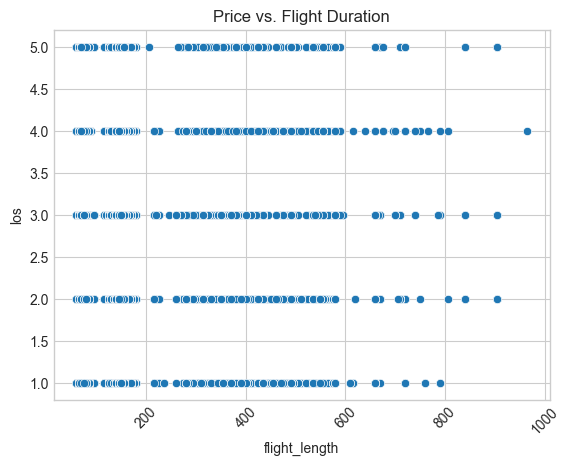

In [56]:
sns.scatterplot(x='flight_length', y='los', data=data1)
plt.title('Price vs. Flight Duration')
plt.xticks(rotation=45)
plt.show()


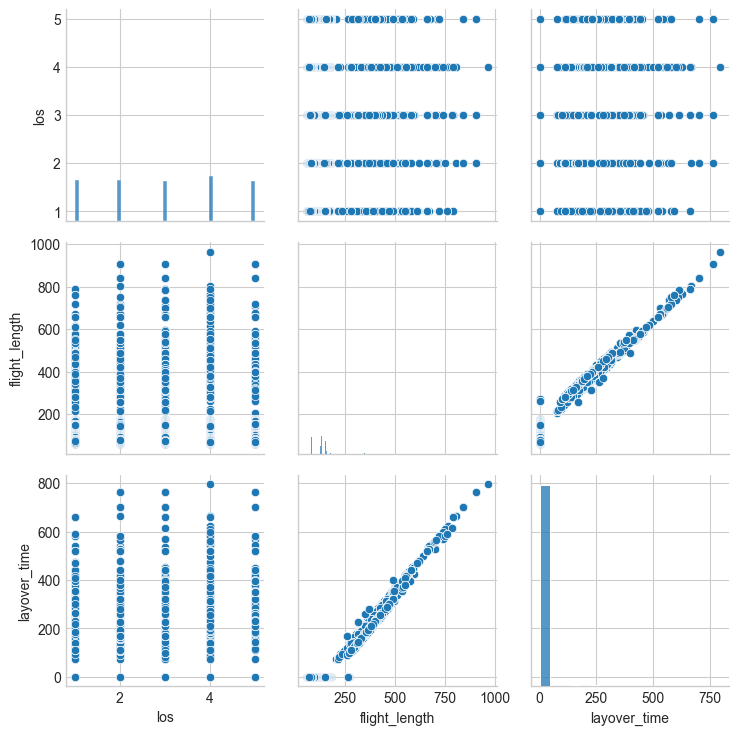

In [57]:
import seaborn as sns
g = sns.PairGrid(data1[['los', 'flight_length', 'layover_time']])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

## PairGrid – Exploring Relationships Between Variables

We analyzed the relationship between:

- **flight_length** (total duration)
- **layover_time** (connection time)
- **los** (ticket price)


### Key Observations:
- There's a **very strong positive relationship** between `layover_time` and `flight_length`, meaning longer travel times typically include longer layovers.
- However, there is **no clear correlation** between `los` (price) and either `flight_length` or `layover_time`.
- This suggests that ticket prices on Kiwi are likely influenced more by external factors such as destination, airline, date, and demand, rather than trip duration or number of stops.


# Remove the outlier (Tukey method: 1.5*IQR)

In [59]:
def remove_route_outliers(group):
    Q1 = group['price'].quantile(0.25)
    Q3 = group['price'].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return group[(group['price'] >= lower_bound) & 
                        (group['price'] <= upper_bound)]

#### Lets visualize before and after removing the outlier (price over route)

C:\Users\LaurenM\AppData\Local\Temp\ipykernel_18092\1894013283.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_cleaned = data1.groupby('route', group_keys=False).apply(remove_route_outliers).reset_index(drop=True)
C:\Users\LaurenM\AppData\Local\Temp\ipykernel_18092\1894013283.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='route', y='price', data=data1, palette='viridis')


Original DataFrame size: 78719
Cleaned DataFrame size: 76713
Number of outliers removed: 2006
Percentage of data removed: 2.55%


C:\Users\LaurenM\AppData\Local\Temp\ipykernel_18092\1894013283.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='route', y='price', data=data_cleaned, palette='magma')



Price Statistics - Original Data:
              Mean Price  Median Price  Min Price  Max Price  Price Std Dev  \
route                                                                         
LONDON_PARIS      121.70        115.82      72.42     275.61          31.51   
LONDON_ROME       150.62        144.85      64.53     359.59          44.95   
PARIS_LONDON      121.34        116.10      74.12     259.54          28.34   
PARIS_ROME        186.99        184.58      72.14     425.25          38.86   
ROME_LONDON       152.04        147.10      67.92     353.95          42.25   
ROME_PARIS        191.93        183.74      73.55     403.27          47.68   

              Total Flights  
route                        
LONDON_PARIS           8585  
LONDON_ROME           14024  
PARIS_LONDON          11850  
PARIS_ROME            10217  
ROME_LONDON           14970  
ROME_PARIS            19073  

Price Statistics - Cleaned Data:
              Mean Price  Median Price  Min Price  Max Pri

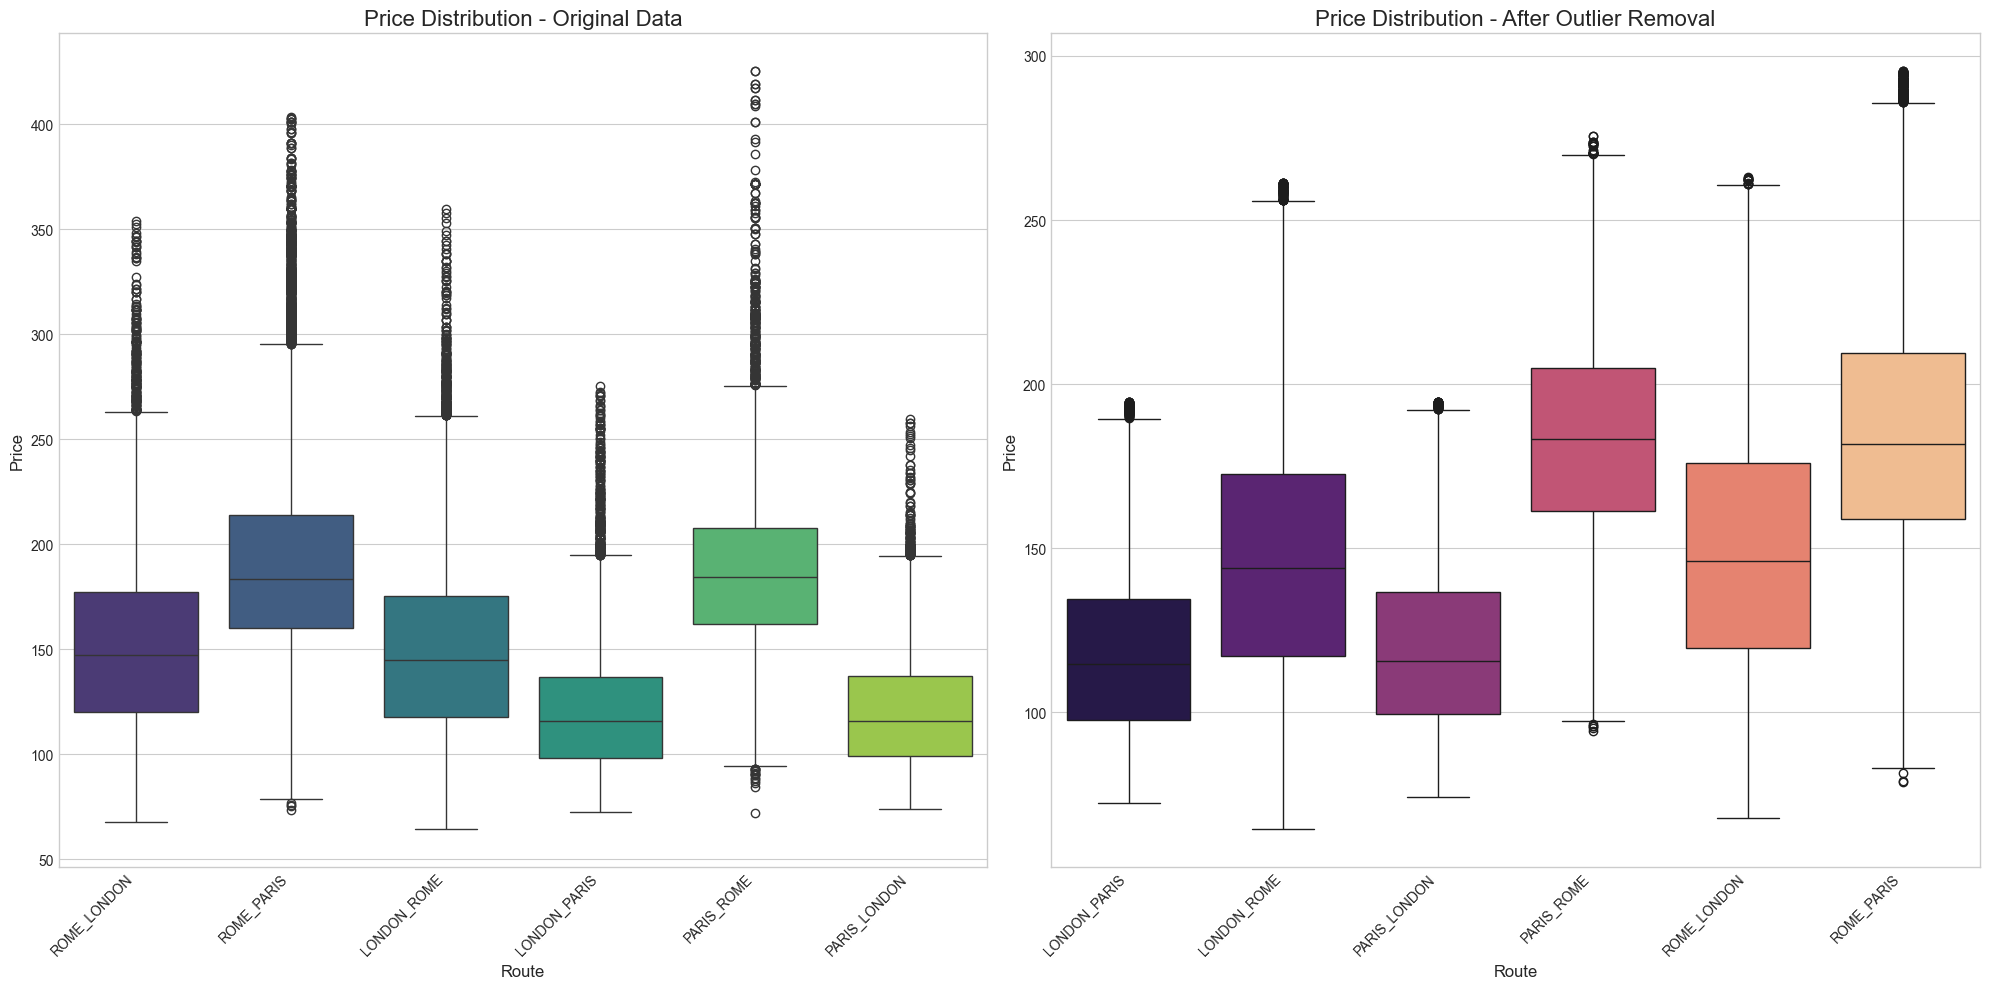

In [60]:
# Group by route and remove outliers
data_cleaned = data1.groupby('route', group_keys=False).apply(remove_route_outliers).reset_index(drop=True)

# Print removal statistics
original_count = len(data1)
cleaned_count = len(data_cleaned)
removed_count = original_count - cleaned_count

print(f"Original DataFrame size: {original_count}")
print(f"Cleaned DataFrame size: {cleaned_count}")
print(f"Number of outliers removed: {removed_count}")
print(f"Percentage of data removed: {removed_count/original_count*100:.2f}%")

# Set up the figure with two subplots
plt.figure(figsize=(20, 10))

# Original Data Distribution
plt.subplot(1, 2, 1)
sns.boxplot(x='route', y='price', data=data1, palette='viridis')
plt.title('Price Distribution - Original Data', fontsize=16)
plt.xlabel('Route', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Cleaned Data Distribution
plt.subplot(1, 2, 2)
sns.boxplot(x='route', y='price', data=data_cleaned, palette='magma')
plt.title('Price Distribution - After Outlier Removal', fontsize=16)
plt.xlabel('Route', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Adjust layout and save
plt.tight_layout()

# Additional statistical summary
print("\nPrice Statistics - Original Data:")
original_stats = data1.groupby('route')['price'].agg([
    ('Mean Price', 'mean'),
    ('Median Price', 'median'),
    ('Min Price', 'min'),
    ('Max Price', 'max'),
    ('Price Std Dev', 'std'),
    ('Total Flights', 'count')
]).round(2)
print(original_stats)

print("\nPrice Statistics - Cleaned Data:")
cleaned_stats = data_cleaned.groupby('route')['price'].agg([
    ('Mean Price', 'mean'),
    ('Median Price', 'median'),
    ('Min Price', 'min'),
    ('Max Price', 'max'),
    ('Price Std Dev', 'std'),
    ('Total Flights', 'count')
]).round(2)
print(cleaned_stats)
data = data_cleaned

### Price Distribution – Kiwi Dataset (Before & After Outlier Removal)

- **Before Cleaning**:
  - All routes showed extreme outliers, especially `PARIS_ROME` and `ROME_PARIS`.
  - `PARIS_ROME` was the most expensive route.
  - `LONDON_PARIS` and `PARIS_LONDON` were the cheapest.

- **After Cleaning**:
  - Outliers removed using Tukey’s IQR method (1.5 * IQR).
  - Distribution became clearer and more focused.
  - Relative price order between routes remained:
    - Expensive: `PARIS_ROME`, `ROME_PARIS`
    - Cheap: `LONDON_PARIS`, `PARIS_LONDON`
  - Cleaning made the data more consistent and better for modeling or reporting.
